In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

In [3]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [4]:
from divers import plot_confusion_matrix

In [5]:
import sys
sys.path.append('./sompyLatmos/')     # Chemin du package
from sompy import SOMFactory
from sompy import SOMData

### Chargement et mise en forme des données

Chargement des différents jeux de représentation

In [6]:
# les imagettes 
x = np.loadtxt("./donnees/x.txt")
x_comp_names = [ "x["+str(i)+"]" for i in range(x.shape[0])]
#
# différentes projections des imagettes
hx = np.loadtxt("./donnees/hx.txt")
hx_comp_names = [ "hx["+str(i)+"]" for i in range(hx.shape[0])]
hy_comp_names = [ "hy["+str(i)+"]" for i in range(hx.shape[0])]
#
hx_hy = np.loadtxt("./donnees/hx_hy.txt")
hx_hy_comp_names = []
hx_hy_comp_names.extend(hx_comp_names)
hx_hy_comp_names.extend(hy_comp_names)
#
pb_comp_names = [ "pb["+str(i)+"]" for i in range(hx.shape[0])]
ph_comp_names = [ "ph["+str(i)+"]" for i in range(hx.shape[0])]
pb_ph = np.loadtxt("./donnees/pb_ph.txt")
pb_ph_comp_names = []
pb_ph_comp_names.extend(pb_comp_names)
pb_ph_comp_names.extend(ph_comp_names)
#
pg_comp_names = [ "pg["+str(i)+"]" for i in range(hx.shape[0])]
pd_comp_names = [ "pd["+str(i)+"]" for i in range(hx.shape[0])]
pg_pd = np.loadtxt("./donnees/pg_pd.txt")
pg_pd_comp_names = []
pg_pd_comp_names.extend(pg_comp_names)
pg_pd_comp_names.extend(pd_comp_names)
#
# combinaisons de projections
hx_hy_pb_ph = np.loadtxt("./donnees/hx_hy_pb_ph.txt")
hx_hy_pb_ph_comp_names = []
hx_hy_pb_ph_comp_names.extend(hx_hy_comp_names)
hx_hy_pb_ph_comp_names.extend(pb_ph_comp_names)
#
hx_hy_pg_pd = np.loadtxt("./donnees/hx_hy_pg_pd.txt")
hx_hy_pg_pd_comp_names = []
hx_hy_pg_pd_comp_names.extend(hx_hy_comp_names)
hx_hy_pg_pd_comp_names.extend(pg_pd_comp_names)


**Choix d'une représentation des données** 

In [7]:
#strChoix = 'x' problematique en théorie et en pratique
#strChoix = 'hx'
#strChoix = 'hx_hy'
#strChoix = 'pb_ph'
#strChoix = 'pg_pd'
#strChoix = 'hx_hy_pb_ph'
strChoix = 'hx_hy_pg_pd'
if strChoix == 'x':
    data = x.T
    comp_names = x_comp_names
elif strChoix == 'hx':
    data = hx.T
    comp_names = hx_comp_names
elif strChoix == 'hx_hy':
    data = hx_hy.T
    comp_names = hx_hy_comp_names
elif strChoix == 'pb_ph':
    data = pb_ph.T
    comp_names = pb_ph_comp_names
elif strChoix == 'pg_pd':
    data = pg_pd.T
    comp_names = pg_pd_comp_names
elif strChoix == 'hx_hy_pb_ph':
    data = hx_hy_pb_ph.T
    comp_names = hx_hy_pb_ph_comp_names
elif strChoix == 'hx_hy_pg_pd':
    data = hx_hy_pg_pd.T
    comp_names = hx_hy_pg_pd_comp_names
else:
    raise ValueError('choix inattendu')
masque=np.ones(len(comp_names))
del x, hx, hx_hy, pb_ph, pg_pd, hx_hy_pb_ph, hx_hy_pg_pd


Ici on a aussi les étiquettes correspondant à chacune des données. On les utilisera par la suite pour voir les performances de **l'algorithme qui est on le rappelle non supervisé**.   
On se servira de ces etiquettes pour évaluer la qualité du "résumé numérique" fourni par la carte topologique.

In [31]:
t = np.loadtxt("./donnees/t.txt").T
t[np.where(t==-1)] = 0
t_label_num = np.where(t==1)[1]
classnames = ['zero','un','deux','trois','quatre','cinq','six','sept','huit','neuf']
reverse_classnames =  {'zero':0,'un':1,'deux':2,'trois':3,'quatre':4,'cinq':5,'six':6,'sept':7,'huit':8,'neuf':9,'Nan':-1}
data_labels = [ classnames[i] for i in t_label_num]
data_labels =  np.array(data_labels)

Ici, on va mettre quelques données de coté pour évaluer les performances de l'apprentissage. Notamment pour évaluer la capacité de la partition réalisée par la carte en terme de classification des chiffres manuscrits.
Là encore, on rappelle que l'algorithme est non supervisé. Les étiquettes '`t`) ne sont pas prises en compte. Lors de l'apprentissage. La partition de la carte sera basée uniquement sur les données apprises (`X`). 
On évaluera la capacité de la carte à exploiter l'information fournie dans `X`.

In [32]:
N = 34*10
# rescale the data, use the traditional train/test split
#data, data_ = data[:N,:], data[N:,:]
#t_label_num, t_label_num_ = t_label_num[:N], t_label_num[N:]
#data_labels,data_labels_ = np.array(data_labels[:N]), np.array(data_labels[N:])
#data.shape

In [33]:
from sklearn.model_selection import train_test_split

data_dev, data_test, data_labels_dev, data_labels_test = train_test_split(data, data_labels, test_size=0.15, random_state=42)
data_train, data_val, data_labels_train, data_labels_val = train_test_split(data_dev, data_labels_dev, test_size=0.15, random_state=42)


**Création d'un objet sData**

In [34]:
sData_train = SOMData(data_train,      # les données 
                comp_names,# les noms des variables
                data_labels_train)

**Affichage des T-SNE**

In [35]:
#sData.plot_tsne()
import itertools

epochs= np.arange(10,120,25)
tmp_phase1=np.arange(2,10,2)
tmp_phase2=np.arange(0.3,3,0.4)



### Création de la carte et apprentissage

#### Création d'une carte topologique (objet sm)

In [36]:
#mapsize=(10,1)
mapsize=(12,12)
#mapsize=(10,10)
#mapsize=(3,7)
sm = SOMFactory().build(sData_train, 
                        mapsize=mapsize,
                        normalization = None, 
                        #initialization='random', # obligatoire pour x
                        initialization='pca',  
                        radius_train ='linear', 
                        name='Des Chiffres',
                        #lattice='rect',
                        lattice='hexa',
                        mask=masque,
                        components_to_plot=((0,1),(0,2),(1,2)))

#### Entraînement de la carte

In [37]:
'''
sm.train(n_job=1, 
         verbose=None, 
         train_rough_len=30, 
         train_rough_radiusin=3,
         train_rough_radiusfin=1,
         train_finetune_len=30,
         train_finetune_radiusin=2.5,
         train_finetune_radiusfin=0.25,
         watch_evolution = False)'''

'\nsm.train(n_job=1, \n         verbose=None, \n         train_rough_len=30, \n         train_rough_radiusin=3,\n         train_rough_radiusfin=1,\n         train_finetune_len=30,\n         train_finetune_radiusin=2.5,\n         train_finetune_radiusfin=0.25,\n         watch_evolution = False)'

In [38]:
#np.where(data_labels_estim[:,None]==np.array(classnames)[None,:])
#data_labels_estim

In [46]:
#np.where(data_labels_estim[:,None]==np.array(classnames_)[None,:])[1]  
np.array([reverse_classnames[x] for x in data_labels_estim]).shape

(62,)

In [45]:
#np.where(data_labels_estim[:,None]==np.array(classnames_)[None,:])[1].shape

(72,)

0it [00:00, ?it/s]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1944  tErr : 0.7341
Epoch : 2 qErr : 0.1876  tErr : 0.7110
Epoch : 3 qErr : 0.1800  tErr : 0.7197
Epoch : 4 qErr : 0.1742  tErr : 0.7168
Epoch : 5 qErr : 0.1690  tErr : 0.7139
Epoch : 6 qErr : 0.1645  tErr : 0.7168
Epoch : 7 qErr : 0.1603  tErr : 0.7486
Epoch : 8 qErr : 0.1560  tErr : 0.7572
Epoch : 9 qErr : 0.1519  tErr : 0.7572


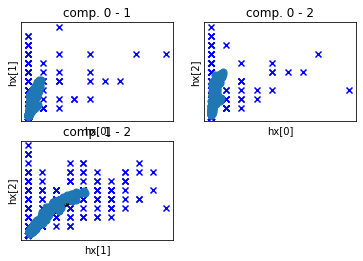

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1003  tErr : 0.7399
Epoch : 1 qErr : 0.0863  tErr : 0.7428
Epoch : 2 qErr : 0.0823  tErr : 0.7399
Epoch : 3 qErr : 0.0810  tErr : 0.7370
Epoch : 4 qErr : 0.0803  tErr : 0.7370
Epoch : 5 qErr : 0.0803  tErr : 0.7370
Epoch : 6 qErr : 0.0803  tErr : 0.7370
Epoch : 7 qErr : 0.0803  tErr : 0.7370
Epoch : 8 qErr : 0.0803  tErr : 0.7370
Epoch : 9 qErr : 0.0803  tErr : 0.7341


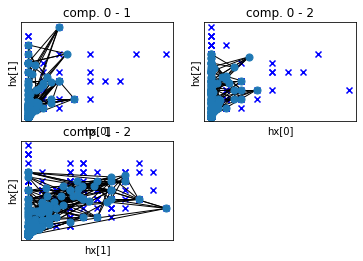

1it [00:10, 10.47s/it]

new best score 0.8870967741935484
Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1944  tErr : 0.7341
Epoch : 2 qErr : 0.1876  tErr : 0.7110
Epoch : 3 qErr : 0.1800  tErr : 0.7197
Epoch : 4 qErr : 0.1742  tErr : 0.7168
Epoch : 5 qErr : 0.1690  tErr : 0.7139
Epoch : 6 qErr : 0.1645  tErr : 0.7168
Epoch : 7 qErr : 0.1603  tErr : 0.7486
Epoch : 8 qErr : 0.1560  tErr : 0.7572
Epoch : 9 qErr : 0.1519  tErr : 0.7572


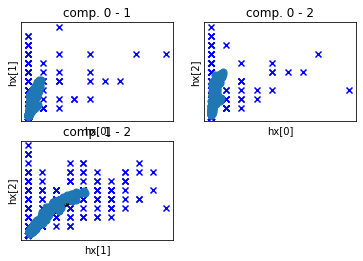

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1247  tErr : 0.7283
Epoch : 1 qErr : 0.1162  tErr : 0.7370
Epoch : 2 qErr : 0.1083  tErr : 0.7283
Epoch : 3 qErr : 0.1004  tErr : 0.7370
Epoch : 4 qErr : 0.0924  tErr : 0.7486
Epoch : 5 qErr : 0.0854  tErr : 0.7399
Epoch : 6 qErr : 0.0802  tErr : 0.7486
Epoch : 7 qErr : 0.0792  tErr : 0.7486
Epoch : 8 qErr : 0.0791  tErr : 0.7486
Epoch : 9 qErr : 0.0791  tErr : 0.7457


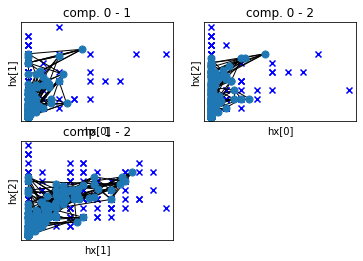

2it [00:20, 10.44s/it]

new best score 0.9354838709677419
Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1944  tErr : 0.7341
Epoch : 2 qErr : 0.1876  tErr : 0.7110
Epoch : 3 qErr : 0.1800  tErr : 0.7197
Epoch : 4 qErr : 0.1742  tErr : 0.7168
Epoch : 5 qErr : 0.1690  tErr : 0.7139
Epoch : 6 qErr : 0.1645  tErr : 0.7168
Epoch : 7 qErr : 0.1603  tErr : 0.7486
Epoch : 8 qErr : 0.1560  tErr : 0.7572
Epoch : 9 qErr : 0.1519  tErr : 0.7572


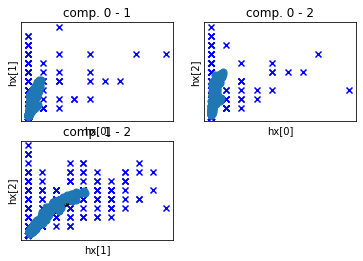

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1445  tErr : 0.7514
Epoch : 1 qErr : 0.1384  tErr : 0.7370
Epoch : 2 qErr : 0.1316  tErr : 0.7370
Epoch : 3 qErr : 0.1240  tErr : 0.7254
Epoch : 4 qErr : 0.1158  tErr : 0.7312
Epoch : 5 qErr : 0.1064  tErr : 0.7283
Epoch : 6 qErr : 0.0949  tErr : 0.7370
Epoch : 7 qErr : 0.0838  tErr : 0.7341
Epoch : 8 qErr : 0.0809  tErr : 0.7514
Epoch : 9 qErr : 0.0803  tErr : 0.7601


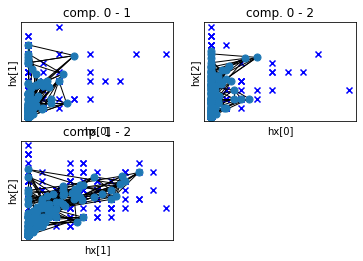

3it [00:31, 10.43s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1944  tErr : 0.7341
Epoch : 2 qErr : 0.1876  tErr : 0.7110
Epoch : 3 qErr : 0.1800  tErr : 0.7197
Epoch : 4 qErr : 0.1742  tErr : 0.7168
Epoch : 5 qErr : 0.1690  tErr : 0.7139
Epoch : 6 qErr : 0.1645  tErr : 0.7168
Epoch : 7 qErr : 0.1603  tErr : 0.7486
Epoch : 8 qErr : 0.1560  tErr : 0.7572
Epoch : 9 qErr : 0.1519  tErr : 0.7572


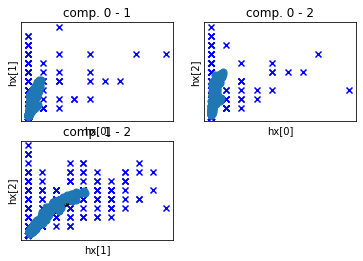

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1635  tErr : 0.7399
Epoch : 1 qErr : 0.1560  tErr : 0.7486
Epoch : 2 qErr : 0.1485  tErr : 0.7601
Epoch : 3 qErr : 0.1408  tErr : 0.7428
Epoch : 4 qErr : 0.1319  tErr : 0.7341
Epoch : 5 qErr : 0.1217  tErr : 0.7283
Epoch : 6 qErr : 0.1098  tErr : 0.7486
Epoch : 7 qErr : 0.0937  tErr : 0.7399
Epoch : 8 qErr : 0.0822  tErr : 0.7457
Epoch : 9 qErr : 0.0815  tErr : 0.7572


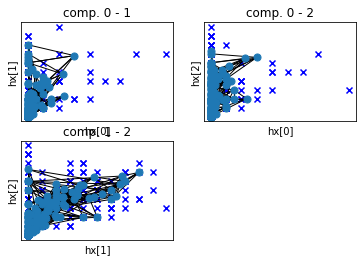

4it [00:41, 10.44s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1944  tErr : 0.7341
Epoch : 2 qErr : 0.1876  tErr : 0.7110
Epoch : 3 qErr : 0.1800  tErr : 0.7197
Epoch : 4 qErr : 0.1742  tErr : 0.7168
Epoch : 5 qErr : 0.1690  tErr : 0.7139
Epoch : 6 qErr : 0.1645  tErr : 0.7168
Epoch : 7 qErr : 0.1603  tErr : 0.7486
Epoch : 8 qErr : 0.1560  tErr : 0.7572
Epoch : 9 qErr : 0.1519  tErr : 0.7572


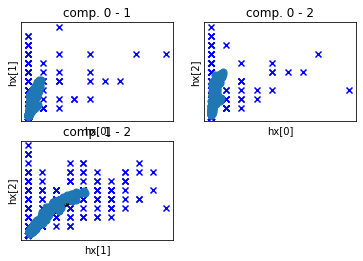

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1797  tErr : 0.7254
Epoch : 1 qErr : 0.1718  tErr : 0.7486
Epoch : 2 qErr : 0.1634  tErr : 0.7457
Epoch : 3 qErr : 0.1540  tErr : 0.7399
Epoch : 4 qErr : 0.1437  tErr : 0.7428
Epoch : 5 qErr : 0.1334  tErr : 0.7283
Epoch : 6 qErr : 0.1210  tErr : 0.7341
Epoch : 7 qErr : 0.1036  tErr : 0.7370
Epoch : 8 qErr : 0.0856  tErr : 0.7283
Epoch : 9 qErr : 0.0817  tErr : 0.7486


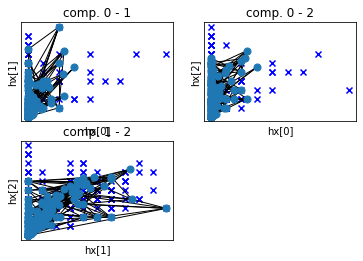

5it [00:52, 10.42s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1944  tErr : 0.7341
Epoch : 2 qErr : 0.1876  tErr : 0.7110
Epoch : 3 qErr : 0.1800  tErr : 0.7197
Epoch : 4 qErr : 0.1742  tErr : 0.7168
Epoch : 5 qErr : 0.1690  tErr : 0.7139
Epoch : 6 qErr : 0.1645  tErr : 0.7168
Epoch : 7 qErr : 0.1603  tErr : 0.7486
Epoch : 8 qErr : 0.1560  tErr : 0.7572
Epoch : 9 qErr : 0.1519  tErr : 0.7572


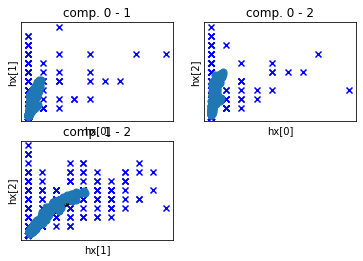

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1920  tErr : 0.7399
Epoch : 1 qErr : 0.1840  tErr : 0.7341
Epoch : 2 qErr : 0.1762  tErr : 0.7514
Epoch : 3 qErr : 0.1668  tErr : 0.7428
Epoch : 4 qErr : 0.1563  tErr : 0.7341
Epoch : 5 qErr : 0.1446  tErr : 0.7225
Epoch : 6 qErr : 0.1294  tErr : 0.7341
Epoch : 7 qErr : 0.1113  tErr : 0.7457
Epoch : 8 qErr : 0.0896  tErr : 0.7543
Epoch : 9 qErr : 0.0808  tErr : 0.7717


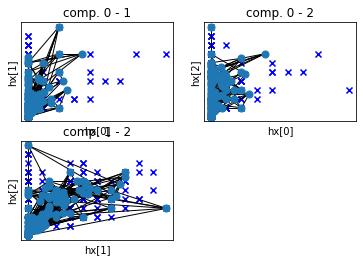

6it [01:02, 10.40s/it]

new best score 0.967741935483871
Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1944  tErr : 0.7341
Epoch : 2 qErr : 0.1876  tErr : 0.7110
Epoch : 3 qErr : 0.1800  tErr : 0.7197
Epoch : 4 qErr : 0.1742  tErr : 0.7168
Epoch : 5 qErr : 0.1690  tErr : 0.7139
Epoch : 6 qErr : 0.1645  tErr : 0.7168
Epoch : 7 qErr : 0.1603  tErr : 0.7486
Epoch : 8 qErr : 0.1560  tErr : 0.7572
Epoch : 9 qErr : 0.1519  tErr : 0.7572


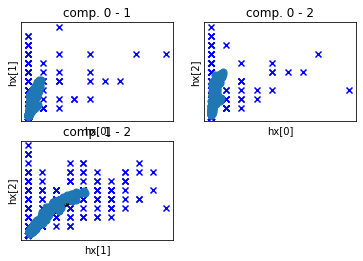

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.2013  tErr : 0.7428
Epoch : 1 qErr : 0.1935  tErr : 0.7457
Epoch : 2 qErr : 0.1859  tErr : 0.7312
Epoch : 3 qErr : 0.1769  tErr : 0.7514
Epoch : 4 qErr : 0.1664  tErr : 0.7543
Epoch : 5 qErr : 0.1546  tErr : 0.7572
Epoch : 6 qErr : 0.1398  tErr : 0.7486
Epoch : 7 qErr : 0.1204  tErr : 0.7601
Epoch : 8 qErr : 0.0905  tErr : 0.7832
Epoch : 9 qErr : 0.0803  tErr : 0.7919


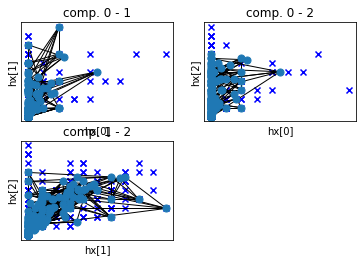

7it [01:12, 10.40s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2113  tErr : 0.7717
Epoch : 1 qErr : 0.2071  tErr : 0.7543
Epoch : 2 qErr : 0.2028  tErr : 0.7457
Epoch : 3 qErr : 0.1977  tErr : 0.7601
Epoch : 4 qErr : 0.1907  tErr : 0.7601
Epoch : 5 qErr : 0.1837  tErr : 0.7630
Epoch : 6 qErr : 0.1759  tErr : 0.7630
Epoch : 7 qErr : 0.1681  tErr : 0.7514
Epoch : 8 qErr : 0.1599  tErr : 0.7601
Epoch : 9 qErr : 0.1513  tErr : 0.7514


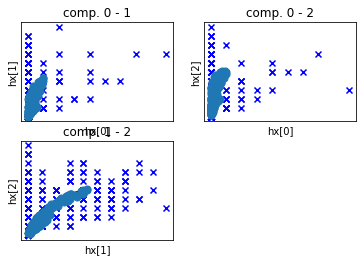

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0969  tErr : 0.7601
Epoch : 1 qErr : 0.0842  tErr : 0.7803
Epoch : 2 qErr : 0.0801  tErr : 0.7890
Epoch : 3 qErr : 0.0778  tErr : 0.7919
Epoch : 4 qErr : 0.0770  tErr : 0.7890
Epoch : 5 qErr : 0.0770  tErr : 0.7890
Epoch : 6 qErr : 0.0770  tErr : 0.7890
Epoch : 7 qErr : 0.0770  tErr : 0.7890
Epoch : 8 qErr : 0.0770  tErr : 0.7890
Epoch : 9 qErr : 0.0770  tErr : 0.7890


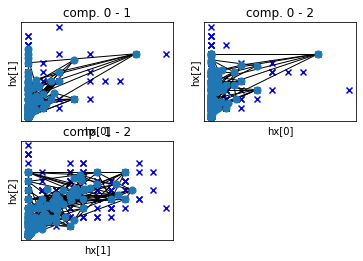

8it [01:23, 10.39s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2113  tErr : 0.7717
Epoch : 1 qErr : 0.2071  tErr : 0.7543
Epoch : 2 qErr : 0.2028  tErr : 0.7457
Epoch : 3 qErr : 0.1977  tErr : 0.7601
Epoch : 4 qErr : 0.1907  tErr : 0.7601
Epoch : 5 qErr : 0.1837  tErr : 0.7630
Epoch : 6 qErr : 0.1759  tErr : 0.7630
Epoch : 7 qErr : 0.1681  tErr : 0.7514
Epoch : 8 qErr : 0.1599  tErr : 0.7601
Epoch : 9 qErr : 0.1513  tErr : 0.7514


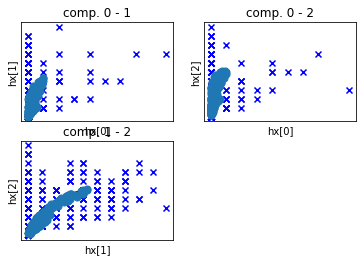

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1245  tErr : 0.7486
Epoch : 1 qErr : 0.1161  tErr : 0.7514
Epoch : 2 qErr : 0.1074  tErr : 0.7688
Epoch : 3 qErr : 0.1004  tErr : 0.7717
Epoch : 4 qErr : 0.0920  tErr : 0.7948
Epoch : 5 qErr : 0.0848  tErr : 0.7977
Epoch : 6 qErr : 0.0798  tErr : 0.7832
Epoch : 7 qErr : 0.0785  tErr : 0.7890
Epoch : 8 qErr : 0.0778  tErr : 0.7948
Epoch : 9 qErr : 0.0777  tErr : 0.7948


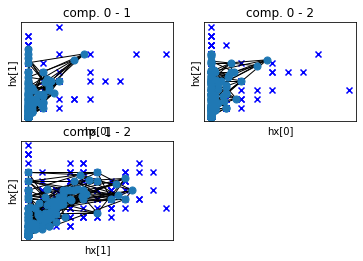

9it [01:33, 10.39s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2113  tErr : 0.7717
Epoch : 1 qErr : 0.2071  tErr : 0.7543
Epoch : 2 qErr : 0.2028  tErr : 0.7457
Epoch : 3 qErr : 0.1977  tErr : 0.7601
Epoch : 4 qErr : 0.1907  tErr : 0.7601
Epoch : 5 qErr : 0.1837  tErr : 0.7630
Epoch : 6 qErr : 0.1759  tErr : 0.7630
Epoch : 7 qErr : 0.1681  tErr : 0.7514
Epoch : 8 qErr : 0.1599  tErr : 0.7601
Epoch : 9 qErr : 0.1513  tErr : 0.7514


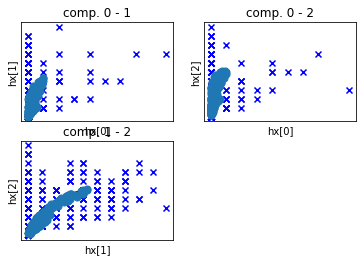

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1438  tErr : 0.7514
Epoch : 1 qErr : 0.1371  tErr : 0.7572
Epoch : 2 qErr : 0.1307  tErr : 0.7601
Epoch : 3 qErr : 0.1235  tErr : 0.7601
Epoch : 4 qErr : 0.1158  tErr : 0.7688
Epoch : 5 qErr : 0.1056  tErr : 0.7746
Epoch : 6 qErr : 0.0922  tErr : 0.7977
Epoch : 7 qErr : 0.0818  tErr : 0.8150
Epoch : 8 qErr : 0.0794  tErr : 0.8121
Epoch : 9 qErr : 0.0794  tErr : 0.8121


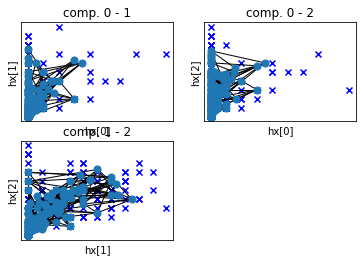

10it [01:44, 10.42s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2113  tErr : 0.7717
Epoch : 1 qErr : 0.2071  tErr : 0.7543
Epoch : 2 qErr : 0.2028  tErr : 0.7457
Epoch : 3 qErr : 0.1977  tErr : 0.7601
Epoch : 4 qErr : 0.1907  tErr : 0.7601
Epoch : 5 qErr : 0.1837  tErr : 0.7630
Epoch : 6 qErr : 0.1759  tErr : 0.7630
Epoch : 7 qErr : 0.1681  tErr : 0.7514
Epoch : 8 qErr : 0.1599  tErr : 0.7601
Epoch : 9 qErr : 0.1513  tErr : 0.7514


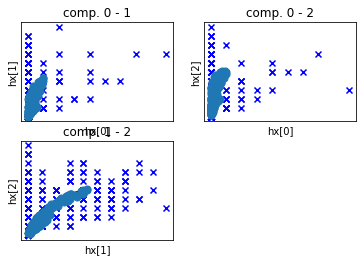

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1619  tErr : 0.7457
Epoch : 1 qErr : 0.1546  tErr : 0.7428
Epoch : 2 qErr : 0.1473  tErr : 0.7457
Epoch : 3 qErr : 0.1394  tErr : 0.7514
Epoch : 4 qErr : 0.1309  tErr : 0.7572
Epoch : 5 qErr : 0.1212  tErr : 0.7630
Epoch : 6 qErr : 0.1093  tErr : 0.7775
Epoch : 7 qErr : 0.0913  tErr : 0.8035
Epoch : 8 qErr : 0.0792  tErr : 0.8064
Epoch : 9 qErr : 0.0788  tErr : 0.8035


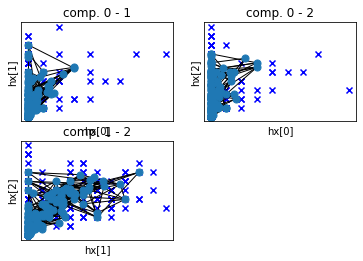

11it [01:54, 10.42s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2113  tErr : 0.7717
Epoch : 1 qErr : 0.2071  tErr : 0.7543
Epoch : 2 qErr : 0.2028  tErr : 0.7457
Epoch : 3 qErr : 0.1977  tErr : 0.7601
Epoch : 4 qErr : 0.1907  tErr : 0.7601
Epoch : 5 qErr : 0.1837  tErr : 0.7630
Epoch : 6 qErr : 0.1759  tErr : 0.7630
Epoch : 7 qErr : 0.1681  tErr : 0.7514
Epoch : 8 qErr : 0.1599  tErr : 0.7601
Epoch : 9 qErr : 0.1513  tErr : 0.7514


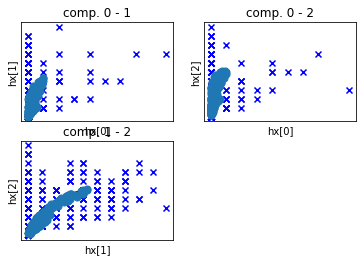

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1768  tErr : 0.7486
Epoch : 1 qErr : 0.1692  tErr : 0.7457
Epoch : 2 qErr : 0.1615  tErr : 0.7370
Epoch : 3 qErr : 0.1530  tErr : 0.7370
Epoch : 4 qErr : 0.1432  tErr : 0.7486
Epoch : 5 qErr : 0.1329  tErr : 0.7514
Epoch : 6 qErr : 0.1205  tErr : 0.7601
Epoch : 7 qErr : 0.1038  tErr : 0.7775
Epoch : 8 qErr : 0.0835  tErr : 0.8092
Epoch : 9 qErr : 0.0801  tErr : 0.7832


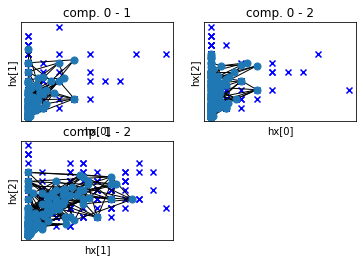

12it [02:05, 10.49s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2113  tErr : 0.7717
Epoch : 1 qErr : 0.2071  tErr : 0.7543
Epoch : 2 qErr : 0.2028  tErr : 0.7457
Epoch : 3 qErr : 0.1977  tErr : 0.7601
Epoch : 4 qErr : 0.1907  tErr : 0.7601
Epoch : 5 qErr : 0.1837  tErr : 0.7630
Epoch : 6 qErr : 0.1759  tErr : 0.7630
Epoch : 7 qErr : 0.1681  tErr : 0.7514
Epoch : 8 qErr : 0.1599  tErr : 0.7601
Epoch : 9 qErr : 0.1513  tErr : 0.7514


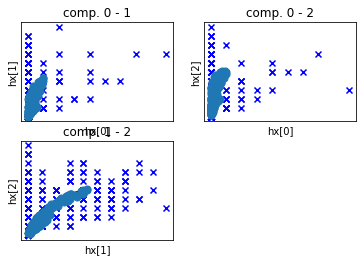

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1888  tErr : 0.7543
Epoch : 1 qErr : 0.1806  tErr : 0.7514
Epoch : 2 qErr : 0.1729  tErr : 0.7486
Epoch : 3 qErr : 0.1642  tErr : 0.7428
Epoch : 4 qErr : 0.1547  tErr : 0.7428
Epoch : 5 qErr : 0.1429  tErr : 0.7543
Epoch : 6 qErr : 0.1299  tErr : 0.7543
Epoch : 7 qErr : 0.1124  tErr : 0.7543
Epoch : 8 qErr : 0.0861  tErr : 0.7659
Epoch : 9 qErr : 0.0798  tErr : 0.7948


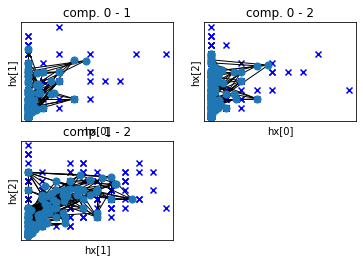

13it [02:15, 10.51s/it]

Training ...
 Rough training...
radius_ini: 3.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2113  tErr : 0.7717
Epoch : 1 qErr : 0.2071  tErr : 0.7543
Epoch : 2 qErr : 0.2028  tErr : 0.7457
Epoch : 3 qErr : 0.1977  tErr : 0.7601
Epoch : 4 qErr : 0.1907  tErr : 0.7601
Epoch : 5 qErr : 0.1837  tErr : 0.7630
Epoch : 6 qErr : 0.1759  tErr : 0.7630
Epoch : 7 qErr : 0.1681  tErr : 0.7514
Epoch : 8 qErr : 0.1599  tErr : 0.7601
Epoch : 9 qErr : 0.1513  tErr : 0.7514


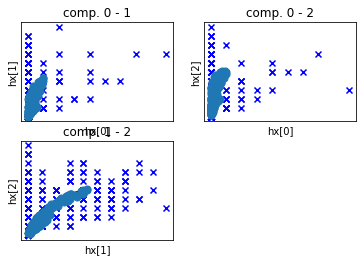

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1986  tErr : 0.7803
Epoch : 1 qErr : 0.1902  tErr : 0.7601
Epoch : 2 qErr : 0.1824  tErr : 0.7688
Epoch : 3 qErr : 0.1737  tErr : 0.7601
Epoch : 4 qErr : 0.1637  tErr : 0.7486
Epoch : 5 qErr : 0.1516  tErr : 0.7514
Epoch : 6 qErr : 0.1372  tErr : 0.7572
Epoch : 7 qErr : 0.1206  tErr : 0.7688
Epoch : 8 qErr : 0.0936  tErr : 0.7717
Epoch : 9 qErr : 0.0816  tErr : 0.7832


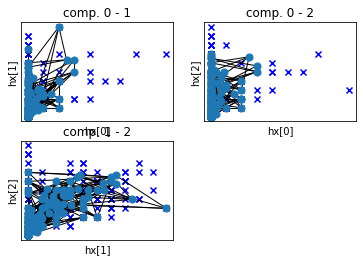

14it [02:26, 10.60s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2203  tErr : 0.7543
Epoch : 1 qErr : 0.2151  tErr : 0.7659
Epoch : 2 qErr : 0.2114  tErr : 0.7717
Epoch : 3 qErr : 0.2075  tErr : 0.7775
Epoch : 4 qErr : 0.2029  tErr : 0.7861
Epoch : 5 qErr : 0.1974  tErr : 0.8035
Epoch : 6 qErr : 0.1893  tErr : 0.8121
Epoch : 7 qErr : 0.1797  tErr : 0.7948
Epoch : 8 qErr : 0.1679  tErr : 0.7977
Epoch : 9 qErr : 0.1536  tErr : 0.7977


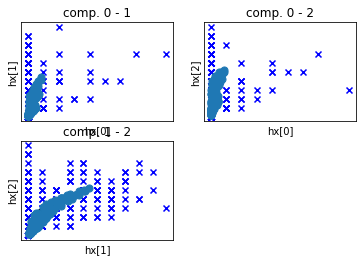

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0985  tErr : 0.8121
Epoch : 1 qErr : 0.0848  tErr : 0.8353
Epoch : 2 qErr : 0.0814  tErr : 0.8353
Epoch : 3 qErr : 0.0804  tErr : 0.8324
Epoch : 4 qErr : 0.0797  tErr : 0.8237
Epoch : 5 qErr : 0.0797  tErr : 0.8237
Epoch : 6 qErr : 0.0797  tErr : 0.8237
Epoch : 7 qErr : 0.0797  tErr : 0.8237
Epoch : 8 qErr : 0.0797  tErr : 0.8237
Epoch : 9 qErr : 0.0797  tErr : 0.8237


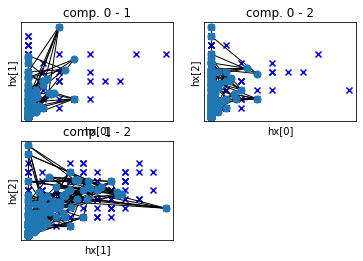

15it [02:36, 10.53s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2203  tErr : 0.7543
Epoch : 1 qErr : 0.2151  tErr : 0.7659
Epoch : 2 qErr : 0.2114  tErr : 0.7717
Epoch : 3 qErr : 0.2075  tErr : 0.7775
Epoch : 4 qErr : 0.2029  tErr : 0.7861
Epoch : 5 qErr : 0.1974  tErr : 0.8035
Epoch : 6 qErr : 0.1893  tErr : 0.8121
Epoch : 7 qErr : 0.1797  tErr : 0.7948
Epoch : 8 qErr : 0.1679  tErr : 0.7977
Epoch : 9 qErr : 0.1536  tErr : 0.7977


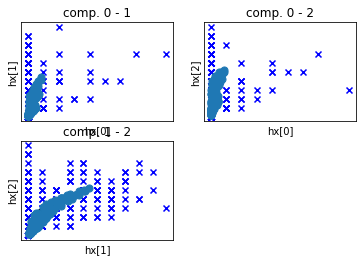

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1239  tErr : 0.8150
Epoch : 1 qErr : 0.1160  tErr : 0.7919
Epoch : 2 qErr : 0.1085  tErr : 0.8035
Epoch : 3 qErr : 0.1002  tErr : 0.8208
Epoch : 4 qErr : 0.0918  tErr : 0.8266
Epoch : 5 qErr : 0.0844  tErr : 0.8237
Epoch : 6 qErr : 0.0806  tErr : 0.8208
Epoch : 7 qErr : 0.0789  tErr : 0.8237
Epoch : 8 qErr : 0.0783  tErr : 0.8208
Epoch : 9 qErr : 0.0779  tErr : 0.8208


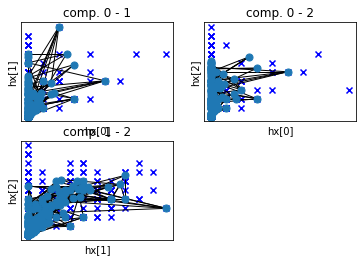

16it [02:47, 10.57s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2203  tErr : 0.7543
Epoch : 1 qErr : 0.2151  tErr : 0.7659
Epoch : 2 qErr : 0.2114  tErr : 0.7717
Epoch : 3 qErr : 0.2075  tErr : 0.7775
Epoch : 4 qErr : 0.2029  tErr : 0.7861
Epoch : 5 qErr : 0.1974  tErr : 0.8035
Epoch : 6 qErr : 0.1893  tErr : 0.8121
Epoch : 7 qErr : 0.1797  tErr : 0.7948
Epoch : 8 qErr : 0.1679  tErr : 0.7977
Epoch : 9 qErr : 0.1536  tErr : 0.7977


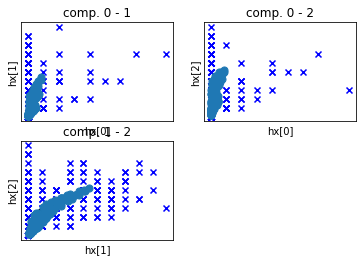

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1445  tErr : 0.8064
Epoch : 1 qErr : 0.1379  tErr : 0.8121
Epoch : 2 qErr : 0.1311  tErr : 0.8121
Epoch : 3 qErr : 0.1241  tErr : 0.8035
Epoch : 4 qErr : 0.1161  tErr : 0.8035
Epoch : 5 qErr : 0.1060  tErr : 0.8092
Epoch : 6 qErr : 0.0934  tErr : 0.8179
Epoch : 7 qErr : 0.0827  tErr : 0.8064
Epoch : 8 qErr : 0.0790  tErr : 0.8208
Epoch : 9 qErr : 0.0790  tErr : 0.8208


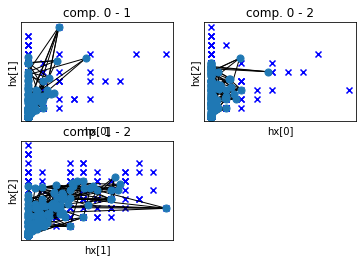

17it [02:57, 10.52s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2203  tErr : 0.7543
Epoch : 1 qErr : 0.2151  tErr : 0.7659
Epoch : 2 qErr : 0.2114  tErr : 0.7717
Epoch : 3 qErr : 0.2075  tErr : 0.7775
Epoch : 4 qErr : 0.2029  tErr : 0.7861
Epoch : 5 qErr : 0.1974  tErr : 0.8035
Epoch : 6 qErr : 0.1893  tErr : 0.8121
Epoch : 7 qErr : 0.1797  tErr : 0.7948
Epoch : 8 qErr : 0.1679  tErr : 0.7977
Epoch : 9 qErr : 0.1536  tErr : 0.7977


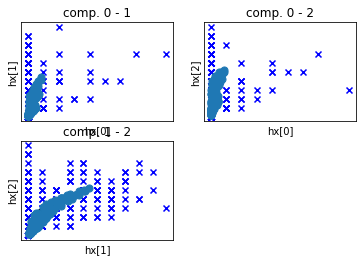

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1635  tErr : 0.8035
Epoch : 1 qErr : 0.1563  tErr : 0.8092
Epoch : 2 qErr : 0.1487  tErr : 0.8035
Epoch : 3 qErr : 0.1406  tErr : 0.7919
Epoch : 4 qErr : 0.1314  tErr : 0.7977
Epoch : 5 qErr : 0.1218  tErr : 0.8064
Epoch : 6 qErr : 0.1099  tErr : 0.8121
Epoch : 7 qErr : 0.0930  tErr : 0.8266
Epoch : 8 qErr : 0.0806  tErr : 0.8237
Epoch : 9 qErr : 0.0783  tErr : 0.8208


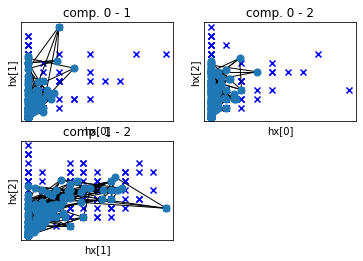

18it [03:08, 10.56s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2203  tErr : 0.7543
Epoch : 1 qErr : 0.2151  tErr : 0.7659
Epoch : 2 qErr : 0.2114  tErr : 0.7717
Epoch : 3 qErr : 0.2075  tErr : 0.7775
Epoch : 4 qErr : 0.2029  tErr : 0.7861
Epoch : 5 qErr : 0.1974  tErr : 0.8035
Epoch : 6 qErr : 0.1893  tErr : 0.8121
Epoch : 7 qErr : 0.1797  tErr : 0.7948
Epoch : 8 qErr : 0.1679  tErr : 0.7977
Epoch : 9 qErr : 0.1536  tErr : 0.7977


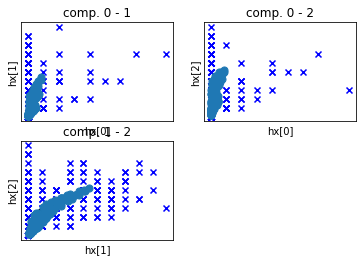

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1790  tErr : 0.8006
Epoch : 1 qErr : 0.1715  tErr : 0.7919
Epoch : 2 qErr : 0.1633  tErr : 0.8006
Epoch : 3 qErr : 0.1540  tErr : 0.7919
Epoch : 4 qErr : 0.1443  tErr : 0.8035
Epoch : 5 qErr : 0.1329  tErr : 0.8064
Epoch : 6 qErr : 0.1198  tErr : 0.8266
Epoch : 7 qErr : 0.1029  tErr : 0.8324
Epoch : 8 qErr : 0.0830  tErr : 0.8468
Epoch : 9 qErr : 0.0789  tErr : 0.8497


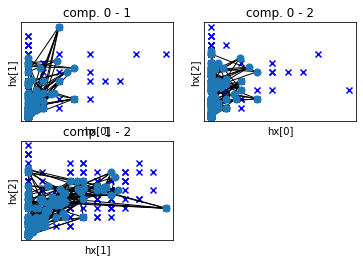

19it [03:19, 10.56s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2203  tErr : 0.7543
Epoch : 1 qErr : 0.2151  tErr : 0.7659
Epoch : 2 qErr : 0.2114  tErr : 0.7717
Epoch : 3 qErr : 0.2075  tErr : 0.7775
Epoch : 4 qErr : 0.2029  tErr : 0.7861
Epoch : 5 qErr : 0.1974  tErr : 0.8035
Epoch : 6 qErr : 0.1893  tErr : 0.8121
Epoch : 7 qErr : 0.1797  tErr : 0.7948
Epoch : 8 qErr : 0.1679  tErr : 0.7977
Epoch : 9 qErr : 0.1536  tErr : 0.7977


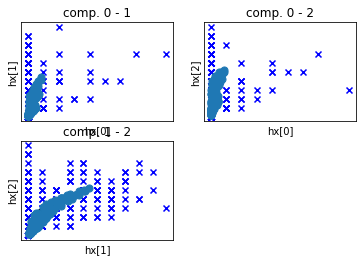

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1910  tErr : 0.8035
Epoch : 1 qErr : 0.1835  tErr : 0.7919
Epoch : 2 qErr : 0.1759  tErr : 0.7977
Epoch : 3 qErr : 0.1664  tErr : 0.7977
Epoch : 4 qErr : 0.1558  tErr : 0.7775
Epoch : 5 qErr : 0.1441  tErr : 0.7659
Epoch : 6 qErr : 0.1310  tErr : 0.7717
Epoch : 7 qErr : 0.1137  tErr : 0.7832
Epoch : 8 qErr : 0.0880  tErr : 0.8092
Epoch : 9 qErr : 0.0798  tErr : 0.8150


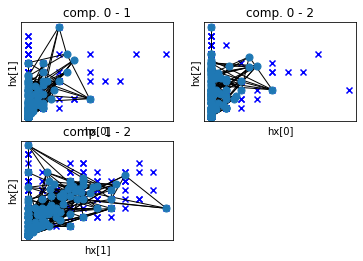

20it [03:29, 10.63s/it]

Training ...
 Rough training...
radius_ini: 4.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2203  tErr : 0.7543
Epoch : 1 qErr : 0.2151  tErr : 0.7659
Epoch : 2 qErr : 0.2114  tErr : 0.7717
Epoch : 3 qErr : 0.2075  tErr : 0.7775
Epoch : 4 qErr : 0.2029  tErr : 0.7861
Epoch : 5 qErr : 0.1974  tErr : 0.8035
Epoch : 6 qErr : 0.1893  tErr : 0.8121
Epoch : 7 qErr : 0.1797  tErr : 0.7948
Epoch : 8 qErr : 0.1679  tErr : 0.7977
Epoch : 9 qErr : 0.1536  tErr : 0.7977


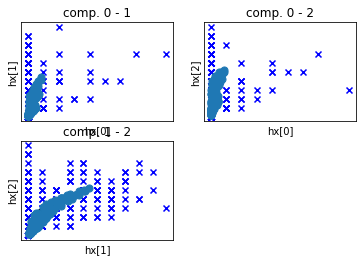

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.2002  tErr : 0.8179
Epoch : 1 qErr : 0.1930  tErr : 0.8064
Epoch : 2 qErr : 0.1854  tErr : 0.7977
Epoch : 3 qErr : 0.1765  tErr : 0.7919
Epoch : 4 qErr : 0.1658  tErr : 0.7977
Epoch : 5 qErr : 0.1526  tErr : 0.7746
Epoch : 6 qErr : 0.1382  tErr : 0.7601
Epoch : 7 qErr : 0.1212  tErr : 0.7746
Epoch : 8 qErr : 0.0939  tErr : 0.7919
Epoch : 9 qErr : 0.0799  tErr : 0.8208


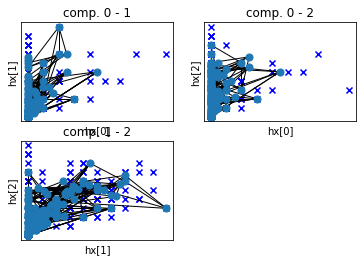

21it [03:40, 10.72s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2290  tErr : 0.7197
Epoch : 1 qErr : 0.2217  tErr : 0.7341
Epoch : 2 qErr : 0.2178  tErr : 0.7543
Epoch : 3 qErr : 0.2135  tErr : 0.7861
Epoch : 4 qErr : 0.2089  tErr : 0.7948
Epoch : 5 qErr : 0.2040  tErr : 0.7977
Epoch : 6 qErr : 0.1976  tErr : 0.7861
Epoch : 7 qErr : 0.1890  tErr : 0.8092
Epoch : 8 qErr : 0.1762  tErr : 0.8179
Epoch : 9 qErr : 0.1583  tErr : 0.8179


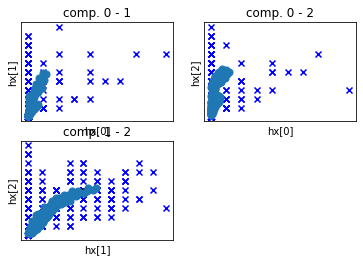

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0986  tErr : 0.7832
Epoch : 1 qErr : 0.0816  tErr : 0.8064
Epoch : 2 qErr : 0.0773  tErr : 0.8295
Epoch : 3 qErr : 0.0756  tErr : 0.8266
Epoch : 4 qErr : 0.0755  tErr : 0.8266
Epoch : 5 qErr : 0.0755  tErr : 0.8266
Epoch : 6 qErr : 0.0755  tErr : 0.8266
Epoch : 7 qErr : 0.0755  tErr : 0.8266
Epoch : 8 qErr : 0.0755  tErr : 0.8266
Epoch : 9 qErr : 0.0755  tErr : 0.8266


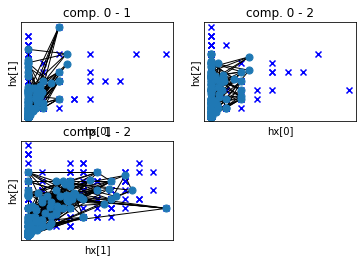

22it [03:51, 10.65s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2290  tErr : 0.7197
Epoch : 1 qErr : 0.2217  tErr : 0.7341
Epoch : 2 qErr : 0.2178  tErr : 0.7543
Epoch : 3 qErr : 0.2135  tErr : 0.7861
Epoch : 4 qErr : 0.2089  tErr : 0.7948
Epoch : 5 qErr : 0.2040  tErr : 0.7977
Epoch : 6 qErr : 0.1976  tErr : 0.7861
Epoch : 7 qErr : 0.1890  tErr : 0.8092
Epoch : 8 qErr : 0.1762  tErr : 0.8179
Epoch : 9 qErr : 0.1583  tErr : 0.8179


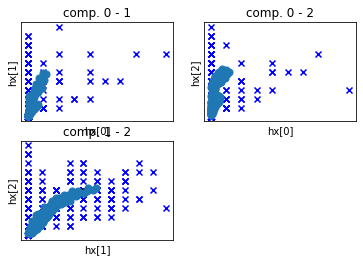

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1269  tErr : 0.7832
Epoch : 1 qErr : 0.1163  tErr : 0.7775
Epoch : 2 qErr : 0.1095  tErr : 0.7832
Epoch : 3 qErr : 0.1011  tErr : 0.7803
Epoch : 4 qErr : 0.0931  tErr : 0.7948
Epoch : 5 qErr : 0.0838  tErr : 0.8150
Epoch : 6 qErr : 0.0787  tErr : 0.8266
Epoch : 7 qErr : 0.0771  tErr : 0.8150
Epoch : 8 qErr : 0.0767  tErr : 0.8179
Epoch : 9 qErr : 0.0767  tErr : 0.8179


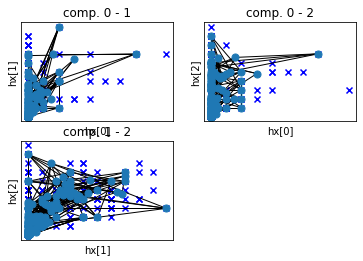

23it [04:01, 10.63s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2290  tErr : 0.7197
Epoch : 1 qErr : 0.2217  tErr : 0.7341
Epoch : 2 qErr : 0.2178  tErr : 0.7543
Epoch : 3 qErr : 0.2135  tErr : 0.7861
Epoch : 4 qErr : 0.2089  tErr : 0.7948
Epoch : 5 qErr : 0.2040  tErr : 0.7977
Epoch : 6 qErr : 0.1976  tErr : 0.7861
Epoch : 7 qErr : 0.1890  tErr : 0.8092
Epoch : 8 qErr : 0.1762  tErr : 0.8179
Epoch : 9 qErr : 0.1583  tErr : 0.8179


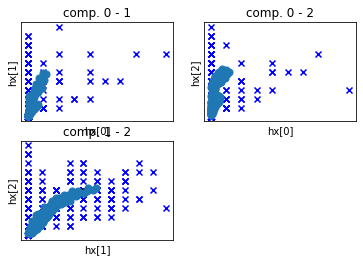

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1471  tErr : 0.8179
Epoch : 1 qErr : 0.1395  tErr : 0.8266
Epoch : 2 qErr : 0.1332  tErr : 0.8237
Epoch : 3 qErr : 0.1254  tErr : 0.8150
Epoch : 4 qErr : 0.1174  tErr : 0.8006
Epoch : 5 qErr : 0.1086  tErr : 0.7890
Epoch : 6 qErr : 0.0965  tErr : 0.7832
Epoch : 7 qErr : 0.0867  tErr : 0.7948
Epoch : 8 qErr : 0.0828  tErr : 0.8035
Epoch : 9 qErr : 0.0827  tErr : 0.8006


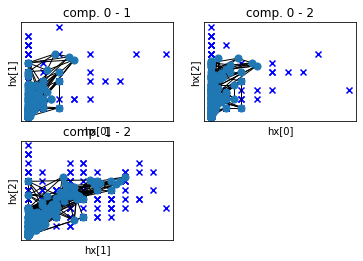

24it [04:13, 10.79s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2290  tErr : 0.7197
Epoch : 1 qErr : 0.2217  tErr : 0.7341
Epoch : 2 qErr : 0.2178  tErr : 0.7543
Epoch : 3 qErr : 0.2135  tErr : 0.7861
Epoch : 4 qErr : 0.2089  tErr : 0.7948
Epoch : 5 qErr : 0.2040  tErr : 0.7977
Epoch : 6 qErr : 0.1976  tErr : 0.7861
Epoch : 7 qErr : 0.1890  tErr : 0.8092
Epoch : 8 qErr : 0.1762  tErr : 0.8179
Epoch : 9 qErr : 0.1583  tErr : 0.8179


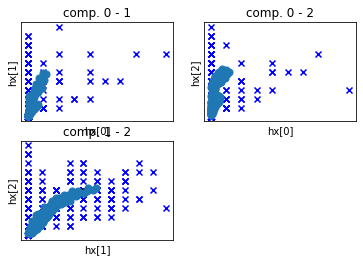

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1665  tErr : 0.8179
Epoch : 1 qErr : 0.1582  tErr : 0.8266
Epoch : 2 qErr : 0.1501  tErr : 0.8237
Epoch : 3 qErr : 0.1413  tErr : 0.8353
Epoch : 4 qErr : 0.1324  tErr : 0.8208
Epoch : 5 qErr : 0.1225  tErr : 0.8092
Epoch : 6 qErr : 0.1113  tErr : 0.7890
Epoch : 7 qErr : 0.0951  tErr : 0.7977
Epoch : 8 qErr : 0.0829  tErr : 0.8006
Epoch : 9 qErr : 0.0796  tErr : 0.8035


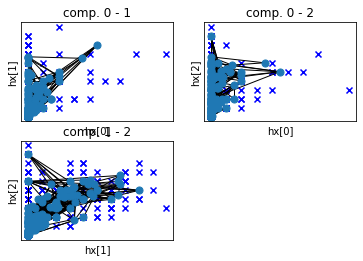

25it [04:23, 10.81s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2290  tErr : 0.7197
Epoch : 1 qErr : 0.2217  tErr : 0.7341
Epoch : 2 qErr : 0.2178  tErr : 0.7543
Epoch : 3 qErr : 0.2135  tErr : 0.7861
Epoch : 4 qErr : 0.2089  tErr : 0.7948
Epoch : 5 qErr : 0.2040  tErr : 0.7977
Epoch : 6 qErr : 0.1976  tErr : 0.7861
Epoch : 7 qErr : 0.1890  tErr : 0.8092
Epoch : 8 qErr : 0.1762  tErr : 0.8179
Epoch : 9 qErr : 0.1583  tErr : 0.8179


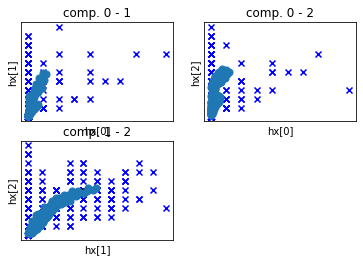

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1813  tErr : 0.8208
Epoch : 1 qErr : 0.1737  tErr : 0.8353
Epoch : 2 qErr : 0.1655  tErr : 0.8382
Epoch : 3 qErr : 0.1557  tErr : 0.8208
Epoch : 4 qErr : 0.1454  tErr : 0.8179
Epoch : 5 qErr : 0.1346  tErr : 0.8150
Epoch : 6 qErr : 0.1214  tErr : 0.8121
Epoch : 7 qErr : 0.1043  tErr : 0.8121
Epoch : 8 qErr : 0.0861  tErr : 0.8035
Epoch : 9 qErr : 0.0824  tErr : 0.8150


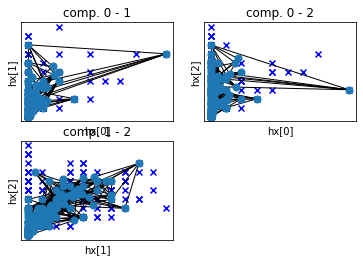

26it [04:34, 10.86s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2290  tErr : 0.7197
Epoch : 1 qErr : 0.2217  tErr : 0.7341
Epoch : 2 qErr : 0.2178  tErr : 0.7543
Epoch : 3 qErr : 0.2135  tErr : 0.7861
Epoch : 4 qErr : 0.2089  tErr : 0.7948
Epoch : 5 qErr : 0.2040  tErr : 0.7977
Epoch : 6 qErr : 0.1976  tErr : 0.7861
Epoch : 7 qErr : 0.1890  tErr : 0.8092
Epoch : 8 qErr : 0.1762  tErr : 0.8179
Epoch : 9 qErr : 0.1583  tErr : 0.8179


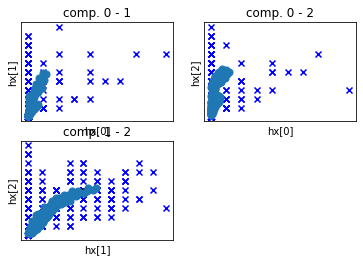

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1924  tErr : 0.8064
Epoch : 1 qErr : 0.1851  tErr : 0.8237
Epoch : 2 qErr : 0.1776  tErr : 0.8324
Epoch : 3 qErr : 0.1683  tErr : 0.8295
Epoch : 4 qErr : 0.1571  tErr : 0.8295
Epoch : 5 qErr : 0.1444  tErr : 0.8266
Epoch : 6 qErr : 0.1313  tErr : 0.8237
Epoch : 7 qErr : 0.1131  tErr : 0.8006
Epoch : 8 qErr : 0.0894  tErr : 0.7919
Epoch : 9 qErr : 0.0831  tErr : 0.7861


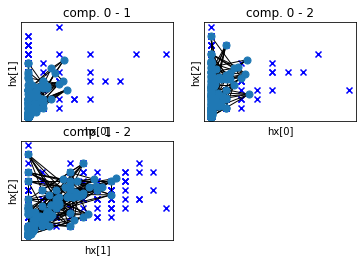

27it [04:45, 10.71s/it]

Training ...
 Rough training...
radius_ini: 5.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2290  tErr : 0.7197
Epoch : 1 qErr : 0.2217  tErr : 0.7341
Epoch : 2 qErr : 0.2178  tErr : 0.7543
Epoch : 3 qErr : 0.2135  tErr : 0.7861
Epoch : 4 qErr : 0.2089  tErr : 0.7948
Epoch : 5 qErr : 0.2040  tErr : 0.7977
Epoch : 6 qErr : 0.1976  tErr : 0.7861
Epoch : 7 qErr : 0.1890  tErr : 0.8092
Epoch : 8 qErr : 0.1762  tErr : 0.8179
Epoch : 9 qErr : 0.1583  tErr : 0.8179


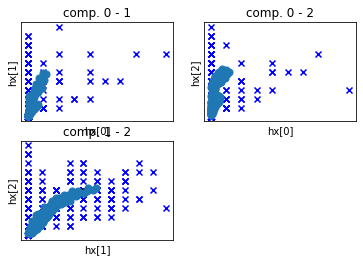

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.2006  tErr : 0.8006
Epoch : 1 qErr : 0.1939  tErr : 0.8150
Epoch : 2 qErr : 0.1872  tErr : 0.8266
Epoch : 3 qErr : 0.1790  tErr : 0.8353
Epoch : 4 qErr : 0.1683  tErr : 0.8382
Epoch : 5 qErr : 0.1543  tErr : 0.8208
Epoch : 6 qErr : 0.1388  tErr : 0.8064
Epoch : 7 qErr : 0.1200  tErr : 0.7977
Epoch : 8 qErr : 0.0908  tErr : 0.7948
Epoch : 9 qErr : 0.0783  tErr : 0.8150


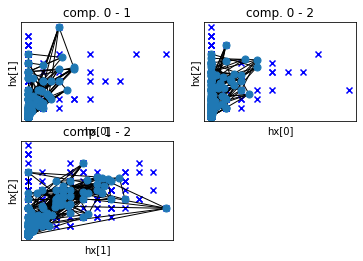

28it [04:55, 10.62s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2363  tErr : 0.6821
Epoch : 1 qErr : 0.2280  tErr : 0.7225
Epoch : 2 qErr : 0.2239  tErr : 0.7341
Epoch : 3 qErr : 0.2192  tErr : 0.7486
Epoch : 4 qErr : 0.2144  tErr : 0.7977
Epoch : 5 qErr : 0.2091  tErr : 0.7890
Epoch : 6 qErr : 0.2029  tErr : 0.7919
Epoch : 7 qErr : 0.1947  tErr : 0.8006
Epoch : 8 qErr : 0.1829  tErr : 0.7948
Epoch : 9 qErr : 0.1601  tErr : 0.8150


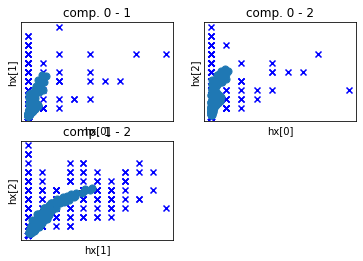

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1022  tErr : 0.7688
Epoch : 1 qErr : 0.0855  tErr : 0.8468
Epoch : 2 qErr : 0.0800  tErr : 0.8237
Epoch : 3 qErr : 0.0783  tErr : 0.8295
Epoch : 4 qErr : 0.0782  tErr : 0.8353
Epoch : 5 qErr : 0.0781  tErr : 0.8353
Epoch : 6 qErr : 0.0780  tErr : 0.8353
Epoch : 7 qErr : 0.0780  tErr : 0.8353
Epoch : 8 qErr : 0.0780  tErr : 0.8353
Epoch : 9 qErr : 0.0780  tErr : 0.8353


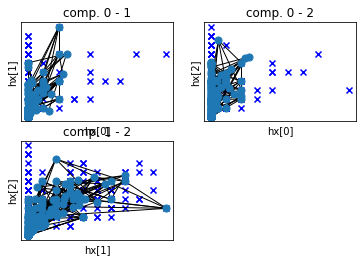

29it [05:06, 10.57s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2363  tErr : 0.6821
Epoch : 1 qErr : 0.2280  tErr : 0.7225
Epoch : 2 qErr : 0.2239  tErr : 0.7341
Epoch : 3 qErr : 0.2192  tErr : 0.7486
Epoch : 4 qErr : 0.2144  tErr : 0.7977
Epoch : 5 qErr : 0.2091  tErr : 0.7890
Epoch : 6 qErr : 0.2029  tErr : 0.7919
Epoch : 7 qErr : 0.1947  tErr : 0.8006
Epoch : 8 qErr : 0.1829  tErr : 0.7948
Epoch : 9 qErr : 0.1601  tErr : 0.8150


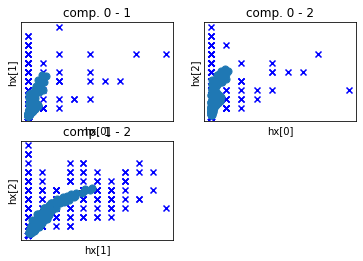

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1275  tErr : 0.7977
Epoch : 1 qErr : 0.1175  tErr : 0.8150
Epoch : 2 qErr : 0.1100  tErr : 0.8208
Epoch : 3 qErr : 0.1023  tErr : 0.8237
Epoch : 4 qErr : 0.0923  tErr : 0.8295
Epoch : 5 qErr : 0.0840  tErr : 0.8786
Epoch : 6 qErr : 0.0792  tErr : 0.8844
Epoch : 7 qErr : 0.0770  tErr : 0.8931
Epoch : 8 qErr : 0.0768  tErr : 0.8931
Epoch : 9 qErr : 0.0768  tErr : 0.8931


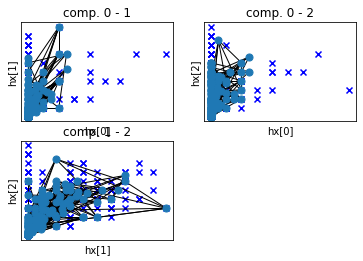

30it [05:16, 10.53s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2363  tErr : 0.6821
Epoch : 1 qErr : 0.2280  tErr : 0.7225
Epoch : 2 qErr : 0.2239  tErr : 0.7341
Epoch : 3 qErr : 0.2192  tErr : 0.7486
Epoch : 4 qErr : 0.2144  tErr : 0.7977
Epoch : 5 qErr : 0.2091  tErr : 0.7890
Epoch : 6 qErr : 0.2029  tErr : 0.7919
Epoch : 7 qErr : 0.1947  tErr : 0.8006
Epoch : 8 qErr : 0.1829  tErr : 0.7948
Epoch : 9 qErr : 0.1601  tErr : 0.8150


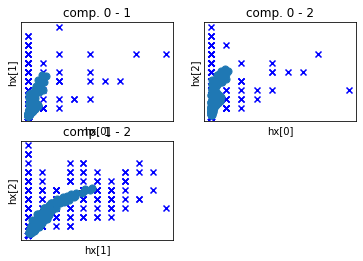

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1484  tErr : 0.8121
Epoch : 1 qErr : 0.1395  tErr : 0.7948
Epoch : 2 qErr : 0.1325  tErr : 0.7919
Epoch : 3 qErr : 0.1256  tErr : 0.7948
Epoch : 4 qErr : 0.1177  tErr : 0.7775
Epoch : 5 qErr : 0.1077  tErr : 0.7659
Epoch : 6 qErr : 0.0956  tErr : 0.7803
Epoch : 7 qErr : 0.0836  tErr : 0.7977
Epoch : 8 qErr : 0.0802  tErr : 0.8150
Epoch : 9 qErr : 0.0788  tErr : 0.8266


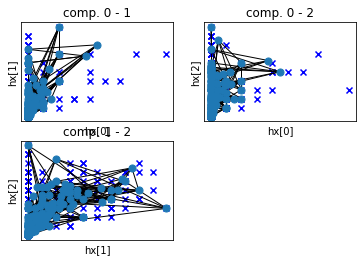

31it [05:27, 10.55s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2363  tErr : 0.6821
Epoch : 1 qErr : 0.2280  tErr : 0.7225
Epoch : 2 qErr : 0.2239  tErr : 0.7341
Epoch : 3 qErr : 0.2192  tErr : 0.7486
Epoch : 4 qErr : 0.2144  tErr : 0.7977
Epoch : 5 qErr : 0.2091  tErr : 0.7890
Epoch : 6 qErr : 0.2029  tErr : 0.7919
Epoch : 7 qErr : 0.1947  tErr : 0.8006
Epoch : 8 qErr : 0.1829  tErr : 0.7948
Epoch : 9 qErr : 0.1601  tErr : 0.8150


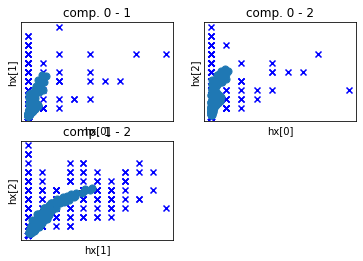

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1672  tErr : 0.8179
Epoch : 1 qErr : 0.1588  tErr : 0.8382
Epoch : 2 qErr : 0.1501  tErr : 0.8353
Epoch : 3 qErr : 0.1416  tErr : 0.8382
Epoch : 4 qErr : 0.1325  tErr : 0.8179
Epoch : 5 qErr : 0.1224  tErr : 0.8121
Epoch : 6 qErr : 0.1105  tErr : 0.7919
Epoch : 7 qErr : 0.0942  tErr : 0.8064
Epoch : 8 qErr : 0.0837  tErr : 0.8266
Epoch : 9 qErr : 0.0816  tErr : 0.8266


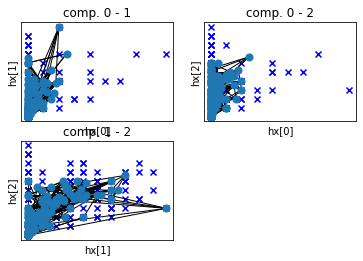

32it [05:38, 10.67s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2363  tErr : 0.6821
Epoch : 1 qErr : 0.2280  tErr : 0.7225
Epoch : 2 qErr : 0.2239  tErr : 0.7341
Epoch : 3 qErr : 0.2192  tErr : 0.7486
Epoch : 4 qErr : 0.2144  tErr : 0.7977
Epoch : 5 qErr : 0.2091  tErr : 0.7890
Epoch : 6 qErr : 0.2029  tErr : 0.7919
Epoch : 7 qErr : 0.1947  tErr : 0.8006
Epoch : 8 qErr : 0.1829  tErr : 0.7948
Epoch : 9 qErr : 0.1601  tErr : 0.8150


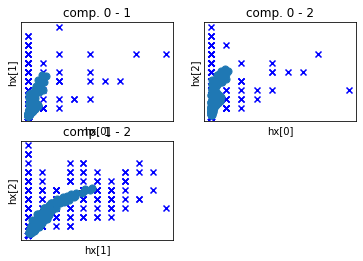

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1817  tErr : 0.8150
Epoch : 1 qErr : 0.1744  tErr : 0.8295
Epoch : 2 qErr : 0.1661  tErr : 0.8353
Epoch : 3 qErr : 0.1563  tErr : 0.8410
Epoch : 4 qErr : 0.1453  tErr : 0.8382
Epoch : 5 qErr : 0.1343  tErr : 0.8353
Epoch : 6 qErr : 0.1221  tErr : 0.8208
Epoch : 7 qErr : 0.1058  tErr : 0.8092
Epoch : 8 qErr : 0.0840  tErr : 0.8035
Epoch : 9 qErr : 0.0795  tErr : 0.7977


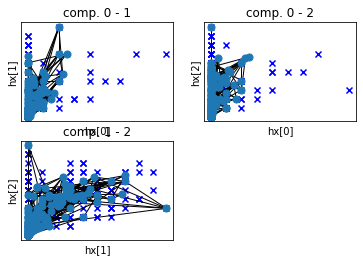

33it [05:48, 10.61s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2363  tErr : 0.6821
Epoch : 1 qErr : 0.2280  tErr : 0.7225
Epoch : 2 qErr : 0.2239  tErr : 0.7341
Epoch : 3 qErr : 0.2192  tErr : 0.7486
Epoch : 4 qErr : 0.2144  tErr : 0.7977
Epoch : 5 qErr : 0.2091  tErr : 0.7890
Epoch : 6 qErr : 0.2029  tErr : 0.7919
Epoch : 7 qErr : 0.1947  tErr : 0.8006
Epoch : 8 qErr : 0.1829  tErr : 0.7948
Epoch : 9 qErr : 0.1601  tErr : 0.8150


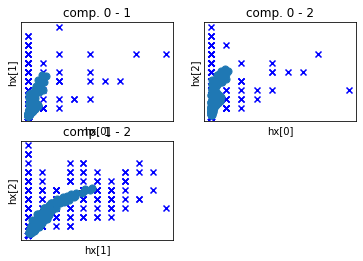

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1922  tErr : 0.7861
Epoch : 1 qErr : 0.1854  tErr : 0.8121
Epoch : 2 qErr : 0.1781  tErr : 0.8237
Epoch : 3 qErr : 0.1694  tErr : 0.8324
Epoch : 4 qErr : 0.1576  tErr : 0.8295
Epoch : 5 qErr : 0.1444  tErr : 0.8237
Epoch : 6 qErr : 0.1309  tErr : 0.8179
Epoch : 7 qErr : 0.1136  tErr : 0.8035
Epoch : 8 qErr : 0.0869  tErr : 0.7919
Epoch : 9 qErr : 0.0786  tErr : 0.7861


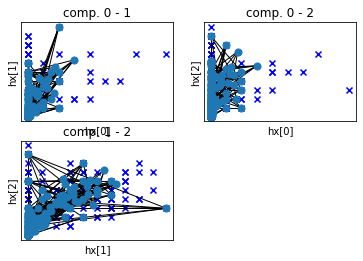

34it [05:59, 10.65s/it]

Training ...
 Rough training...
radius_ini: 6.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2363  tErr : 0.6821
Epoch : 1 qErr : 0.2280  tErr : 0.7225
Epoch : 2 qErr : 0.2239  tErr : 0.7341
Epoch : 3 qErr : 0.2192  tErr : 0.7486
Epoch : 4 qErr : 0.2144  tErr : 0.7977
Epoch : 5 qErr : 0.2091  tErr : 0.7890
Epoch : 6 qErr : 0.2029  tErr : 0.7919
Epoch : 7 qErr : 0.1947  tErr : 0.8006
Epoch : 8 qErr : 0.1829  tErr : 0.7948
Epoch : 9 qErr : 0.1601  tErr : 0.8150


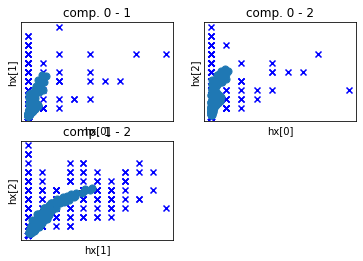

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.2003  tErr : 0.7948
Epoch : 1 qErr : 0.1942  tErr : 0.8092
Epoch : 2 qErr : 0.1872  tErr : 0.8179
Epoch : 3 qErr : 0.1790  tErr : 0.8353
Epoch : 4 qErr : 0.1685  tErr : 0.8266
Epoch : 5 qErr : 0.1548  tErr : 0.8266
Epoch : 6 qErr : 0.1387  tErr : 0.8179
Epoch : 7 qErr : 0.1199  tErr : 0.8266
Epoch : 8 qErr : 0.0915  tErr : 0.8295
Epoch : 9 qErr : 0.0788  tErr : 0.8295


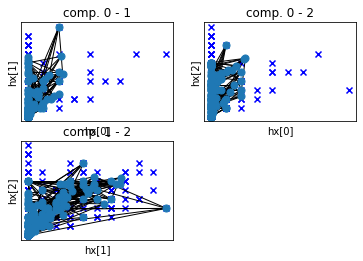

35it [06:09, 10.60s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2420  tErr : 0.6532
Epoch : 1 qErr : 0.2339  tErr : 0.6908
Epoch : 2 qErr : 0.2296  tErr : 0.7110
Epoch : 3 qErr : 0.2245  tErr : 0.7341
Epoch : 4 qErr : 0.2192  tErr : 0.7601
Epoch : 5 qErr : 0.2135  tErr : 0.7861
Epoch : 6 qErr : 0.2070  tErr : 0.7890
Epoch : 7 qErr : 0.1989  tErr : 0.8006
Epoch : 8 qErr : 0.1867  tErr : 0.8121
Epoch : 9 qErr : 0.1642  tErr : 0.7919


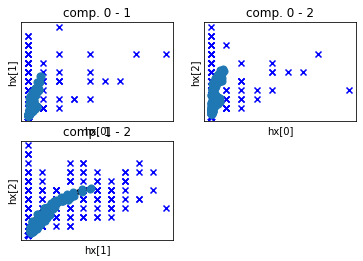

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.0999  tErr : 0.7948
Epoch : 1 qErr : 0.0837  tErr : 0.7861
Epoch : 2 qErr : 0.0797  tErr : 0.7919
Epoch : 3 qErr : 0.0787  tErr : 0.7861
Epoch : 4 qErr : 0.0771  tErr : 0.7977
Epoch : 5 qErr : 0.0767  tErr : 0.8006
Epoch : 6 qErr : 0.0766  tErr : 0.8006
Epoch : 7 qErr : 0.0766  tErr : 0.8006
Epoch : 8 qErr : 0.0766  tErr : 0.8006
Epoch : 9 qErr : 0.0766  tErr : 0.8006


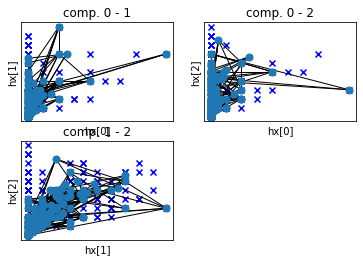

36it [06:20, 10.53s/it]

new best score 0.9838709677419355
Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2420  tErr : 0.6532
Epoch : 1 qErr : 0.2339  tErr : 0.6908
Epoch : 2 qErr : 0.2296  tErr : 0.7110
Epoch : 3 qErr : 0.2245  tErr : 0.7341
Epoch : 4 qErr : 0.2192  tErr : 0.7601
Epoch : 5 qErr : 0.2135  tErr : 0.7861
Epoch : 6 qErr : 0.2070  tErr : 0.7890
Epoch : 7 qErr : 0.1989  tErr : 0.8006
Epoch : 8 qErr : 0.1867  tErr : 0.8121
Epoch : 9 qErr : 0.1642  tErr : 0.7919


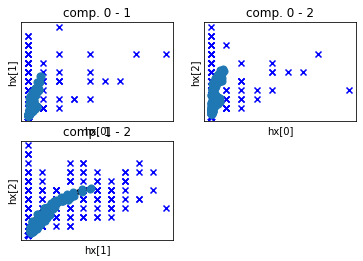

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1298  tErr : 0.7861
Epoch : 1 qErr : 0.1178  tErr : 0.7890
Epoch : 2 qErr : 0.1096  tErr : 0.7948
Epoch : 3 qErr : 0.1012  tErr : 0.7948
Epoch : 4 qErr : 0.0921  tErr : 0.7803
Epoch : 5 qErr : 0.0832  tErr : 0.7601
Epoch : 6 qErr : 0.0772  tErr : 0.7572
Epoch : 7 qErr : 0.0760  tErr : 0.7543
Epoch : 8 qErr : 0.0760  tErr : 0.7543
Epoch : 9 qErr : 0.0760  tErr : 0.7543


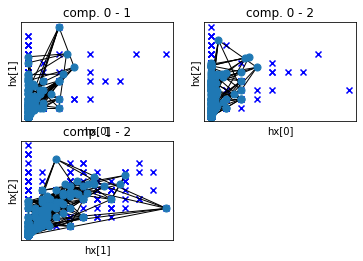

37it [06:30, 10.53s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2420  tErr : 0.6532
Epoch : 1 qErr : 0.2339  tErr : 0.6908
Epoch : 2 qErr : 0.2296  tErr : 0.7110
Epoch : 3 qErr : 0.2245  tErr : 0.7341
Epoch : 4 qErr : 0.2192  tErr : 0.7601
Epoch : 5 qErr : 0.2135  tErr : 0.7861
Epoch : 6 qErr : 0.2070  tErr : 0.7890
Epoch : 7 qErr : 0.1989  tErr : 0.8006
Epoch : 8 qErr : 0.1867  tErr : 0.8121
Epoch : 9 qErr : 0.1642  tErr : 0.7919


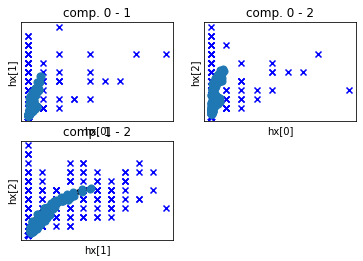

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1508  tErr : 0.8006
Epoch : 1 qErr : 0.1415  tErr : 0.8035
Epoch : 2 qErr : 0.1335  tErr : 0.8121
Epoch : 3 qErr : 0.1255  tErr : 0.8064
Epoch : 4 qErr : 0.1167  tErr : 0.8006
Epoch : 5 qErr : 0.1066  tErr : 0.7861
Epoch : 6 qErr : 0.0949  tErr : 0.7832
Epoch : 7 qErr : 0.0851  tErr : 0.8121
Epoch : 8 qErr : 0.0833  tErr : 0.8121
Epoch : 9 qErr : 0.0833  tErr : 0.8121


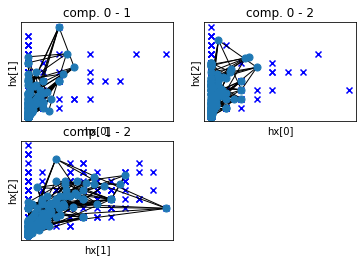

38it [06:41, 10.48s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2420  tErr : 0.6532
Epoch : 1 qErr : 0.2339  tErr : 0.6908
Epoch : 2 qErr : 0.2296  tErr : 0.7110
Epoch : 3 qErr : 0.2245  tErr : 0.7341
Epoch : 4 qErr : 0.2192  tErr : 0.7601
Epoch : 5 qErr : 0.2135  tErr : 0.7861
Epoch : 6 qErr : 0.2070  tErr : 0.7890
Epoch : 7 qErr : 0.1989  tErr : 0.8006
Epoch : 8 qErr : 0.1867  tErr : 0.8121
Epoch : 9 qErr : 0.1642  tErr : 0.7919


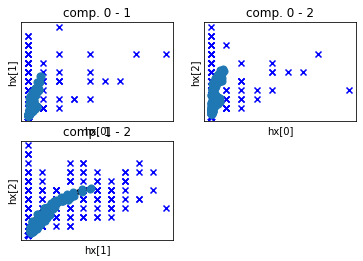

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1685  tErr : 0.8035
Epoch : 1 qErr : 0.1603  tErr : 0.8121
Epoch : 2 qErr : 0.1510  tErr : 0.8295
Epoch : 3 qErr : 0.1420  tErr : 0.8353
Epoch : 4 qErr : 0.1331  tErr : 0.8179
Epoch : 5 qErr : 0.1226  tErr : 0.8121
Epoch : 6 qErr : 0.1110  tErr : 0.8064
Epoch : 7 qErr : 0.0947  tErr : 0.8006
Epoch : 8 qErr : 0.0829  tErr : 0.7948
Epoch : 9 qErr : 0.0805  tErr : 0.7977


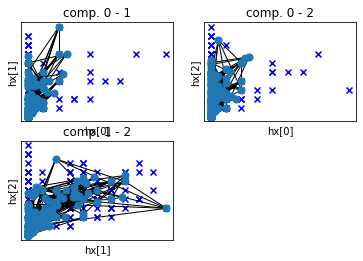

39it [06:51, 10.46s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2420  tErr : 0.6532
Epoch : 1 qErr : 0.2339  tErr : 0.6908
Epoch : 2 qErr : 0.2296  tErr : 0.7110
Epoch : 3 qErr : 0.2245  tErr : 0.7341
Epoch : 4 qErr : 0.2192  tErr : 0.7601
Epoch : 5 qErr : 0.2135  tErr : 0.7861
Epoch : 6 qErr : 0.2070  tErr : 0.7890
Epoch : 7 qErr : 0.1989  tErr : 0.8006
Epoch : 8 qErr : 0.1867  tErr : 0.8121
Epoch : 9 qErr : 0.1642  tErr : 0.7919


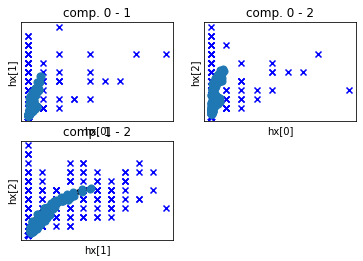

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1820  tErr : 0.8237
Epoch : 1 qErr : 0.1745  tErr : 0.8150
Epoch : 2 qErr : 0.1664  tErr : 0.8208
Epoch : 3 qErr : 0.1565  tErr : 0.8382
Epoch : 4 qErr : 0.1458  tErr : 0.8439
Epoch : 5 qErr : 0.1347  tErr : 0.8266
Epoch : 6 qErr : 0.1218  tErr : 0.8208
Epoch : 7 qErr : 0.1051  tErr : 0.8295
Epoch : 8 qErr : 0.0841  tErr : 0.8382
Epoch : 9 qErr : 0.0793  tErr : 0.8439


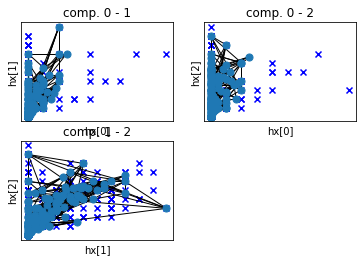

40it [07:01, 10.47s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2420  tErr : 0.6532
Epoch : 1 qErr : 0.2339  tErr : 0.6908
Epoch : 2 qErr : 0.2296  tErr : 0.7110
Epoch : 3 qErr : 0.2245  tErr : 0.7341
Epoch : 4 qErr : 0.2192  tErr : 0.7601
Epoch : 5 qErr : 0.2135  tErr : 0.7861
Epoch : 6 qErr : 0.2070  tErr : 0.7890
Epoch : 7 qErr : 0.1989  tErr : 0.8006
Epoch : 8 qErr : 0.1867  tErr : 0.8121
Epoch : 9 qErr : 0.1642  tErr : 0.7919


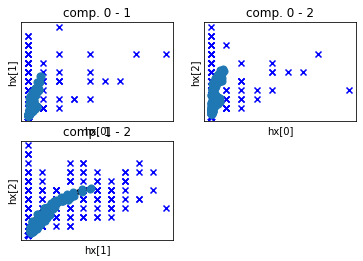

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1922  tErr : 0.7832
Epoch : 1 qErr : 0.1854  tErr : 0.7977
Epoch : 2 qErr : 0.1784  tErr : 0.8035
Epoch : 3 qErr : 0.1695  tErr : 0.8179
Epoch : 4 qErr : 0.1571  tErr : 0.8295
Epoch : 5 qErr : 0.1440  tErr : 0.8295
Epoch : 6 qErr : 0.1302  tErr : 0.7977
Epoch : 7 qErr : 0.1130  tErr : 0.7890
Epoch : 8 qErr : 0.0863  tErr : 0.8035
Epoch : 9 qErr : 0.0789  tErr : 0.8092


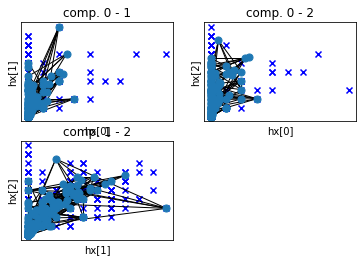

41it [07:12, 10.43s/it]

Training ...
 Rough training...
radius_ini: 7.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2420  tErr : 0.6532
Epoch : 1 qErr : 0.2339  tErr : 0.6908
Epoch : 2 qErr : 0.2296  tErr : 0.7110
Epoch : 3 qErr : 0.2245  tErr : 0.7341
Epoch : 4 qErr : 0.2192  tErr : 0.7601
Epoch : 5 qErr : 0.2135  tErr : 0.7861
Epoch : 6 qErr : 0.2070  tErr : 0.7890
Epoch : 7 qErr : 0.1989  tErr : 0.8006
Epoch : 8 qErr : 0.1867  tErr : 0.8121
Epoch : 9 qErr : 0.1642  tErr : 0.7919


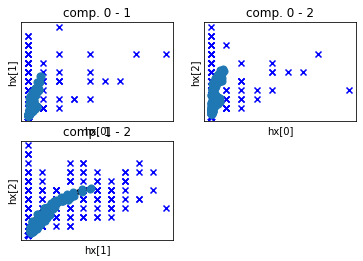

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.2002  tErr : 0.7948
Epoch : 1 qErr : 0.1942  tErr : 0.8121
Epoch : 2 qErr : 0.1876  tErr : 0.8035
Epoch : 3 qErr : 0.1797  tErr : 0.8179
Epoch : 4 qErr : 0.1695  tErr : 0.8121
Epoch : 5 qErr : 0.1547  tErr : 0.8092
Epoch : 6 qErr : 0.1387  tErr : 0.8121
Epoch : 7 qErr : 0.1207  tErr : 0.8150
Epoch : 8 qErr : 0.0940  tErr : 0.8150
Epoch : 9 qErr : 0.0824  tErr : 0.8179


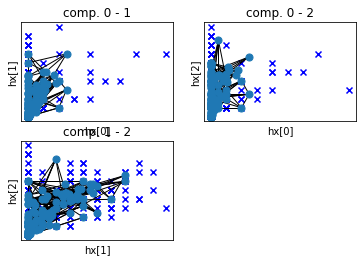

42it [07:22, 10.42s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2463  tErr : 0.6098
Epoch : 1 qErr : 0.2388  tErr : 0.6503
Epoch : 2 qErr : 0.2345  tErr : 0.6821
Epoch : 3 qErr : 0.2294  tErr : 0.7139
Epoch : 4 qErr : 0.2236  tErr : 0.7428
Epoch : 5 qErr : 0.2174  tErr : 0.7717
Epoch : 6 qErr : 0.2106  tErr : 0.7832
Epoch : 7 qErr : 0.2023  tErr : 0.7948
Epoch : 8 qErr : 0.1901  tErr : 0.7803
Epoch : 9 qErr : 0.1668  tErr : 0.8237


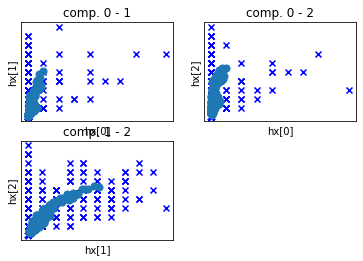

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1014  tErr : 0.8150
Epoch : 1 qErr : 0.0806  tErr : 0.8092
Epoch : 2 qErr : 0.0748  tErr : 0.8092
Epoch : 3 qErr : 0.0727  tErr : 0.8092
Epoch : 4 qErr : 0.0726  tErr : 0.8092
Epoch : 5 qErr : 0.0725  tErr : 0.8092
Epoch : 6 qErr : 0.0725  tErr : 0.8092
Epoch : 7 qErr : 0.0725  tErr : 0.8092
Epoch : 8 qErr : 0.0725  tErr : 0.8092
Epoch : 9 qErr : 0.0725  tErr : 0.8121


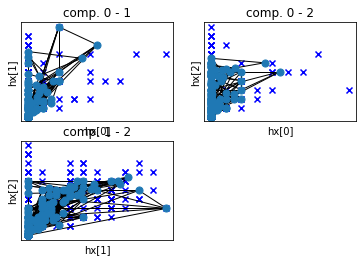

43it [07:33, 10.42s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2463  tErr : 0.6098
Epoch : 1 qErr : 0.2388  tErr : 0.6503
Epoch : 2 qErr : 0.2345  tErr : 0.6821
Epoch : 3 qErr : 0.2294  tErr : 0.7139
Epoch : 4 qErr : 0.2236  tErr : 0.7428
Epoch : 5 qErr : 0.2174  tErr : 0.7717
Epoch : 6 qErr : 0.2106  tErr : 0.7832
Epoch : 7 qErr : 0.2023  tErr : 0.7948
Epoch : 8 qErr : 0.1901  tErr : 0.7803
Epoch : 9 qErr : 0.1668  tErr : 0.8237


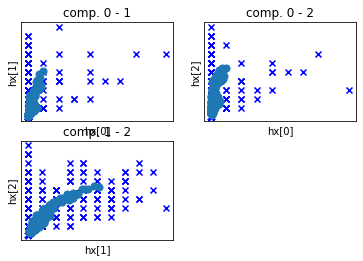

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1321  tErr : 0.8295
Epoch : 1 qErr : 0.1194  tErr : 0.8237
Epoch : 2 qErr : 0.1108  tErr : 0.8150
Epoch : 3 qErr : 0.1029  tErr : 0.8121
Epoch : 4 qErr : 0.0941  tErr : 0.8150
Epoch : 5 qErr : 0.0852  tErr : 0.8295
Epoch : 6 qErr : 0.0792  tErr : 0.8410
Epoch : 7 qErr : 0.0781  tErr : 0.8439
Epoch : 8 qErr : 0.0781  tErr : 0.8439
Epoch : 9 qErr : 0.0781  tErr : 0.8439


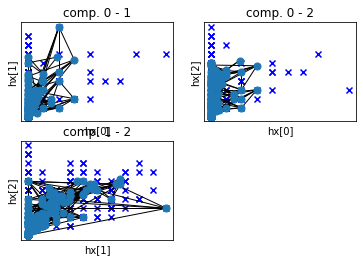

44it [07:43, 10.40s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2463  tErr : 0.6098
Epoch : 1 qErr : 0.2388  tErr : 0.6503
Epoch : 2 qErr : 0.2345  tErr : 0.6821
Epoch : 3 qErr : 0.2294  tErr : 0.7139
Epoch : 4 qErr : 0.2236  tErr : 0.7428
Epoch : 5 qErr : 0.2174  tErr : 0.7717
Epoch : 6 qErr : 0.2106  tErr : 0.7832
Epoch : 7 qErr : 0.2023  tErr : 0.7948
Epoch : 8 qErr : 0.1901  tErr : 0.7803
Epoch : 9 qErr : 0.1668  tErr : 0.8237


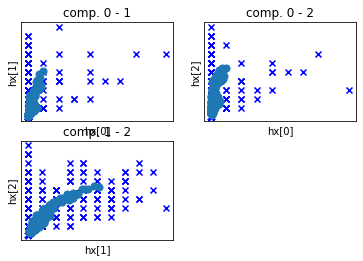

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1525  tErr : 0.8208
Epoch : 1 qErr : 0.1437  tErr : 0.8324
Epoch : 2 qErr : 0.1360  tErr : 0.8410
Epoch : 3 qErr : 0.1279  tErr : 0.8208
Epoch : 4 qErr : 0.1185  tErr : 0.8237
Epoch : 5 qErr : 0.1067  tErr : 0.8208
Epoch : 6 qErr : 0.0933  tErr : 0.8237
Epoch : 7 qErr : 0.0810  tErr : 0.8353
Epoch : 8 qErr : 0.0774  tErr : 0.8382
Epoch : 9 qErr : 0.0771  tErr : 0.8382


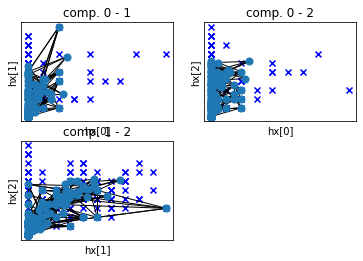

45it [07:53, 10.39s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2463  tErr : 0.6098
Epoch : 1 qErr : 0.2388  tErr : 0.6503
Epoch : 2 qErr : 0.2345  tErr : 0.6821
Epoch : 3 qErr : 0.2294  tErr : 0.7139
Epoch : 4 qErr : 0.2236  tErr : 0.7428
Epoch : 5 qErr : 0.2174  tErr : 0.7717
Epoch : 6 qErr : 0.2106  tErr : 0.7832
Epoch : 7 qErr : 0.2023  tErr : 0.7948
Epoch : 8 qErr : 0.1901  tErr : 0.7803
Epoch : 9 qErr : 0.1668  tErr : 0.8237


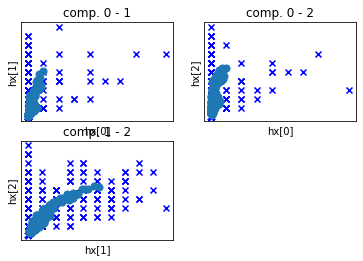

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1696  tErr : 0.8237
Epoch : 1 qErr : 0.1605  tErr : 0.8208
Epoch : 2 qErr : 0.1517  tErr : 0.8237
Epoch : 3 qErr : 0.1436  tErr : 0.8179
Epoch : 4 qErr : 0.1343  tErr : 0.8150
Epoch : 5 qErr : 0.1236  tErr : 0.8064
Epoch : 6 qErr : 0.1102  tErr : 0.8150
Epoch : 7 qErr : 0.0928  tErr : 0.8208
Epoch : 8 qErr : 0.0811  tErr : 0.8295
Epoch : 9 qErr : 0.0798  tErr : 0.8410


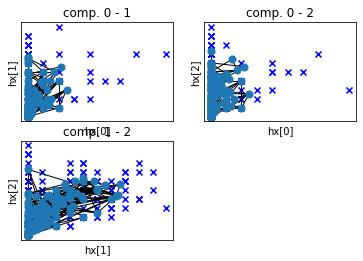

46it [08:04, 10.40s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2463  tErr : 0.6098
Epoch : 1 qErr : 0.2388  tErr : 0.6503
Epoch : 2 qErr : 0.2345  tErr : 0.6821
Epoch : 3 qErr : 0.2294  tErr : 0.7139
Epoch : 4 qErr : 0.2236  tErr : 0.7428
Epoch : 5 qErr : 0.2174  tErr : 0.7717
Epoch : 6 qErr : 0.2106  tErr : 0.7832
Epoch : 7 qErr : 0.2023  tErr : 0.7948
Epoch : 8 qErr : 0.1901  tErr : 0.7803
Epoch : 9 qErr : 0.1668  tErr : 0.8237


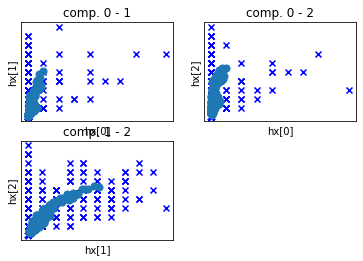

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1828  tErr : 0.8092
Epoch : 1 qErr : 0.1748  tErr : 0.8064
Epoch : 2 qErr : 0.1655  tErr : 0.8035
Epoch : 3 qErr : 0.1557  tErr : 0.8150
Epoch : 4 qErr : 0.1454  tErr : 0.8092
Epoch : 5 qErr : 0.1345  tErr : 0.7977
Epoch : 6 qErr : 0.1216  tErr : 0.8121
Epoch : 7 qErr : 0.1043  tErr : 0.7948
Epoch : 8 qErr : 0.0838  tErr : 0.7948
Epoch : 9 qErr : 0.0795  tErr : 0.8006


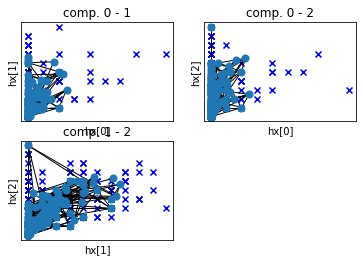

47it [08:15, 10.49s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2463  tErr : 0.6098
Epoch : 1 qErr : 0.2388  tErr : 0.6503
Epoch : 2 qErr : 0.2345  tErr : 0.6821
Epoch : 3 qErr : 0.2294  tErr : 0.7139
Epoch : 4 qErr : 0.2236  tErr : 0.7428
Epoch : 5 qErr : 0.2174  tErr : 0.7717
Epoch : 6 qErr : 0.2106  tErr : 0.7832
Epoch : 7 qErr : 0.2023  tErr : 0.7948
Epoch : 8 qErr : 0.1901  tErr : 0.7803
Epoch : 9 qErr : 0.1668  tErr : 0.8237


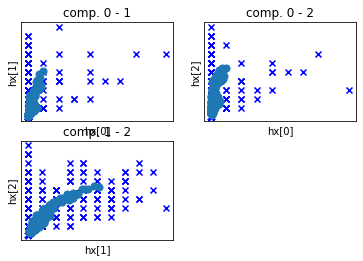

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1928  tErr : 0.7977
Epoch : 1 qErr : 0.1858  tErr : 0.7948
Epoch : 2 qErr : 0.1776  tErr : 0.8006
Epoch : 3 qErr : 0.1676  tErr : 0.7977
Epoch : 4 qErr : 0.1563  tErr : 0.8064
Epoch : 5 qErr : 0.1447  tErr : 0.8035
Epoch : 6 qErr : 0.1316  tErr : 0.7861
Epoch : 7 qErr : 0.1133  tErr : 0.8006
Epoch : 8 qErr : 0.0874  tErr : 0.7717
Epoch : 9 qErr : 0.0779  tErr : 0.7803


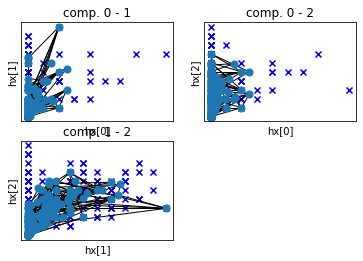

48it [08:25, 10.51s/it]

Training ...
 Rough training...
radius_ini: 8.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2463  tErr : 0.6098
Epoch : 1 qErr : 0.2388  tErr : 0.6503
Epoch : 2 qErr : 0.2345  tErr : 0.6821
Epoch : 3 qErr : 0.2294  tErr : 0.7139
Epoch : 4 qErr : 0.2236  tErr : 0.7428
Epoch : 5 qErr : 0.2174  tErr : 0.7717
Epoch : 6 qErr : 0.2106  tErr : 0.7832
Epoch : 7 qErr : 0.2023  tErr : 0.7948
Epoch : 8 qErr : 0.1901  tErr : 0.7803
Epoch : 9 qErr : 0.1668  tErr : 0.8237


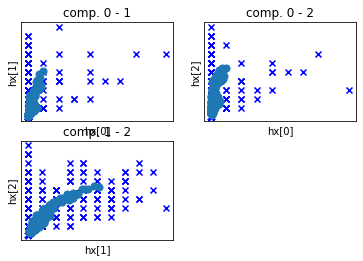

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.2005  tErr : 0.7919
Epoch : 1 qErr : 0.1943  tErr : 0.7948
Epoch : 2 qErr : 0.1878  tErr : 0.7977
Epoch : 3 qErr : 0.1789  tErr : 0.8150
Epoch : 4 qErr : 0.1679  tErr : 0.8064
Epoch : 5 qErr : 0.1546  tErr : 0.8064
Epoch : 6 qErr : 0.1407  tErr : 0.8035
Epoch : 7 qErr : 0.1219  tErr : 0.7890
Epoch : 8 qErr : 0.0907  tErr : 0.8324
Epoch : 9 qErr : 0.0776  tErr : 0.8439


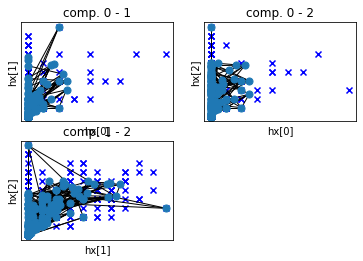

49it [08:36, 10.61s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2496  tErr : 0.5896
Epoch : 1 qErr : 0.2429  tErr : 0.6272
Epoch : 2 qErr : 0.2388  tErr : 0.6561
Epoch : 3 qErr : 0.2338  tErr : 0.7023
Epoch : 4 qErr : 0.2279  tErr : 0.7139
Epoch : 5 qErr : 0.2212  tErr : 0.7486
Epoch : 6 qErr : 0.2139  tErr : 0.7919
Epoch : 7 qErr : 0.2054  tErr : 0.7832
Epoch : 8 qErr : 0.1930  tErr : 0.7775
Epoch : 9 qErr : 0.1692  tErr : 0.7948


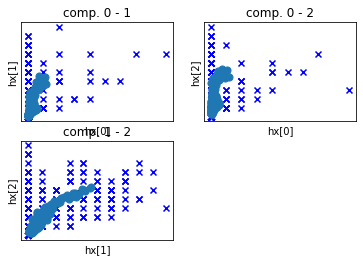

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1039  tErr : 0.7977
Epoch : 1 qErr : 0.0850  tErr : 0.8064
Epoch : 2 qErr : 0.0806  tErr : 0.8179
Epoch : 3 qErr : 0.0782  tErr : 0.8150
Epoch : 4 qErr : 0.0772  tErr : 0.8092
Epoch : 5 qErr : 0.0768  tErr : 0.8121
Epoch : 6 qErr : 0.0767  tErr : 0.8121
Epoch : 7 qErr : 0.0767  tErr : 0.8121
Epoch : 8 qErr : 0.0767  tErr : 0.8121
Epoch : 9 qErr : 0.0767  tErr : 0.8121


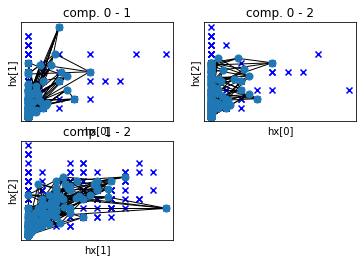

50it [08:46, 10.59s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2496  tErr : 0.5896
Epoch : 1 qErr : 0.2429  tErr : 0.6272
Epoch : 2 qErr : 0.2388  tErr : 0.6561
Epoch : 3 qErr : 0.2338  tErr : 0.7023
Epoch : 4 qErr : 0.2279  tErr : 0.7139
Epoch : 5 qErr : 0.2212  tErr : 0.7486
Epoch : 6 qErr : 0.2139  tErr : 0.7919
Epoch : 7 qErr : 0.2054  tErr : 0.7832
Epoch : 8 qErr : 0.1930  tErr : 0.7775
Epoch : 9 qErr : 0.1692  tErr : 0.7948


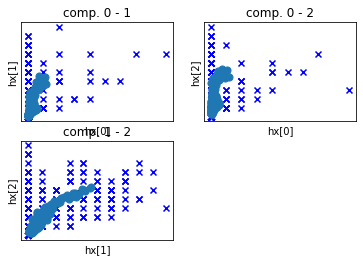

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1335  tErr : 0.7948
Epoch : 1 qErr : 0.1207  tErr : 0.8179
Epoch : 2 qErr : 0.1121  tErr : 0.8295
Epoch : 3 qErr : 0.1035  tErr : 0.8266
Epoch : 4 qErr : 0.0947  tErr : 0.8324
Epoch : 5 qErr : 0.0863  tErr : 0.8324
Epoch : 6 qErr : 0.0801  tErr : 0.8353
Epoch : 7 qErr : 0.0787  tErr : 0.8266
Epoch : 8 qErr : 0.0785  tErr : 0.8266
Epoch : 9 qErr : 0.0785  tErr : 0.8266


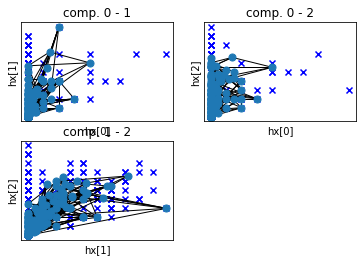

51it [08:57, 10.59s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2496  tErr : 0.5896
Epoch : 1 qErr : 0.2429  tErr : 0.6272
Epoch : 2 qErr : 0.2388  tErr : 0.6561
Epoch : 3 qErr : 0.2338  tErr : 0.7023
Epoch : 4 qErr : 0.2279  tErr : 0.7139
Epoch : 5 qErr : 0.2212  tErr : 0.7486
Epoch : 6 qErr : 0.2139  tErr : 0.7919
Epoch : 7 qErr : 0.2054  tErr : 0.7832
Epoch : 8 qErr : 0.1930  tErr : 0.7775
Epoch : 9 qErr : 0.1692  tErr : 0.7948


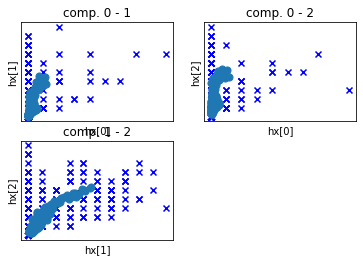

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1529  tErr : 0.8035
Epoch : 1 qErr : 0.1437  tErr : 0.8121
Epoch : 2 qErr : 0.1358  tErr : 0.7977
Epoch : 3 qErr : 0.1276  tErr : 0.8035
Epoch : 4 qErr : 0.1182  tErr : 0.8092
Epoch : 5 qErr : 0.1083  tErr : 0.8208
Epoch : 6 qErr : 0.0960  tErr : 0.8121
Epoch : 7 qErr : 0.0840  tErr : 0.8035
Epoch : 8 qErr : 0.0811  tErr : 0.8006
Epoch : 9 qErr : 0.0800  tErr : 0.8006


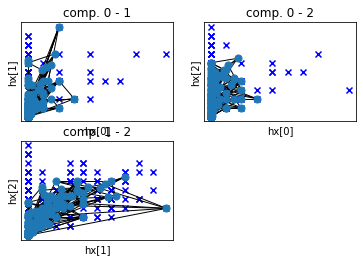

52it [09:08, 10.61s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2496  tErr : 0.5896
Epoch : 1 qErr : 0.2429  tErr : 0.6272
Epoch : 2 qErr : 0.2388  tErr : 0.6561
Epoch : 3 qErr : 0.2338  tErr : 0.7023
Epoch : 4 qErr : 0.2279  tErr : 0.7139
Epoch : 5 qErr : 0.2212  tErr : 0.7486
Epoch : 6 qErr : 0.2139  tErr : 0.7919
Epoch : 7 qErr : 0.2054  tErr : 0.7832
Epoch : 8 qErr : 0.1930  tErr : 0.7775
Epoch : 9 qErr : 0.1692  tErr : 0.7948


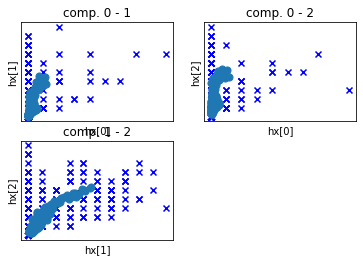

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1699  tErr : 0.8092
Epoch : 1 qErr : 0.1614  tErr : 0.8179
Epoch : 2 qErr : 0.1525  tErr : 0.8208
Epoch : 3 qErr : 0.1431  tErr : 0.8266
Epoch : 4 qErr : 0.1335  tErr : 0.8266
Epoch : 5 qErr : 0.1234  tErr : 0.8121
Epoch : 6 qErr : 0.1102  tErr : 0.8121
Epoch : 7 qErr : 0.0923  tErr : 0.8324
Epoch : 8 qErr : 0.0787  tErr : 0.8497
Epoch : 9 qErr : 0.0768  tErr : 0.8555


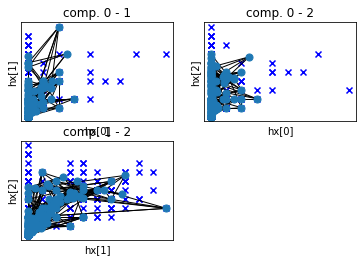

53it [09:18, 10.58s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2496  tErr : 0.5896
Epoch : 1 qErr : 0.2429  tErr : 0.6272
Epoch : 2 qErr : 0.2388  tErr : 0.6561
Epoch : 3 qErr : 0.2338  tErr : 0.7023
Epoch : 4 qErr : 0.2279  tErr : 0.7139
Epoch : 5 qErr : 0.2212  tErr : 0.7486
Epoch : 6 qErr : 0.2139  tErr : 0.7919
Epoch : 7 qErr : 0.2054  tErr : 0.7832
Epoch : 8 qErr : 0.1930  tErr : 0.7775
Epoch : 9 qErr : 0.1692  tErr : 0.7948


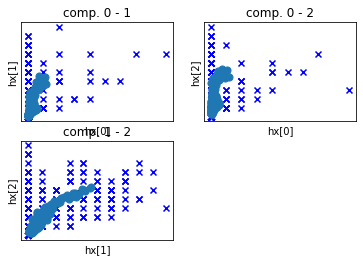

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1832  tErr : 0.8092
Epoch : 1 qErr : 0.1753  tErr : 0.8266
Epoch : 2 qErr : 0.1666  tErr : 0.8237
Epoch : 3 qErr : 0.1566  tErr : 0.8266
Epoch : 4 qErr : 0.1463  tErr : 0.8121
Epoch : 5 qErr : 0.1351  tErr : 0.7948
Epoch : 6 qErr : 0.1228  tErr : 0.8006
Epoch : 7 qErr : 0.1051  tErr : 0.8179
Epoch : 8 qErr : 0.0848  tErr : 0.8439
Epoch : 9 qErr : 0.0800  tErr : 0.8410


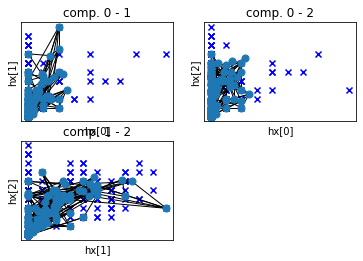

54it [09:29, 10.55s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2496  tErr : 0.5896
Epoch : 1 qErr : 0.2429  tErr : 0.6272
Epoch : 2 qErr : 0.2388  tErr : 0.6561
Epoch : 3 qErr : 0.2338  tErr : 0.7023
Epoch : 4 qErr : 0.2279  tErr : 0.7139
Epoch : 5 qErr : 0.2212  tErr : 0.7486
Epoch : 6 qErr : 0.2139  tErr : 0.7919
Epoch : 7 qErr : 0.2054  tErr : 0.7832
Epoch : 8 qErr : 0.1930  tErr : 0.7775
Epoch : 9 qErr : 0.1692  tErr : 0.7948


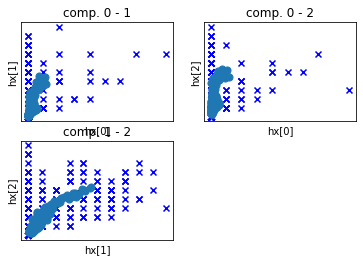

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.1932  tErr : 0.7977
Epoch : 1 qErr : 0.1862  tErr : 0.7977
Epoch : 2 qErr : 0.1788  tErr : 0.8121
Epoch : 3 qErr : 0.1694  tErr : 0.8092
Epoch : 4 qErr : 0.1576  tErr : 0.8092
Epoch : 5 qErr : 0.1453  tErr : 0.8092
Epoch : 6 qErr : 0.1317  tErr : 0.7919
Epoch : 7 qErr : 0.1145  tErr : 0.8092
Epoch : 8 qErr : 0.0875  tErr : 0.8121
Epoch : 9 qErr : 0.0799  tErr : 0.8295


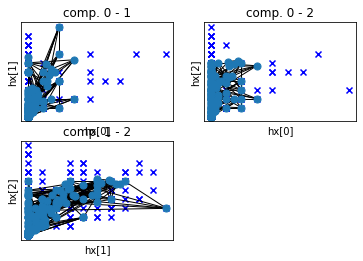

55it [09:39, 10.55s/it]

Training ...
 Rough training...
radius_ini: 9.000 , radius_final: 1.250, trainlen: 10

Epoch : 0 qErr : 0.2496  tErr : 0.5896
Epoch : 1 qErr : 0.2429  tErr : 0.6272
Epoch : 2 qErr : 0.2388  tErr : 0.6561
Epoch : 3 qErr : 0.2338  tErr : 0.7023
Epoch : 4 qErr : 0.2279  tErr : 0.7139
Epoch : 5 qErr : 0.2212  tErr : 0.7486
Epoch : 6 qErr : 0.2139  tErr : 0.7919
Epoch : 7 qErr : 0.2054  tErr : 0.7832
Epoch : 8 qErr : 0.1930  tErr : 0.7775
Epoch : 9 qErr : 0.1692  tErr : 0.7948


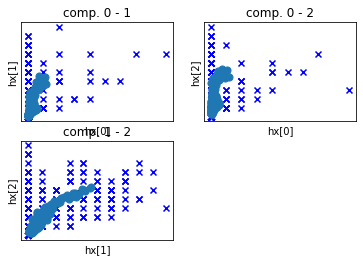

Finetune training
radius_ini: 2.700 , radius_final: 0.100, trainlen: 10

Epoch : 0 qErr : 0.2007  tErr : 0.7861
Epoch : 1 qErr : 0.1946  tErr : 0.7948
Epoch : 2 qErr : 0.1877  tErr : 0.7977
Epoch : 3 qErr : 0.1799  tErr : 0.8035
Epoch : 4 qErr : 0.1695  tErr : 0.8064
Epoch : 5 qErr : 0.1552  tErr : 0.8208
Epoch : 6 qErr : 0.1391  tErr : 0.8121
Epoch : 7 qErr : 0.1211  tErr : 0.7890
Epoch : 8 qErr : 0.0924  tErr : 0.7948
Epoch : 9 qErr : 0.0822  tErr : 0.7948


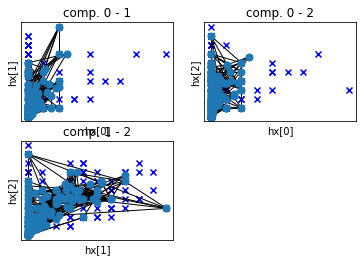

56it [09:50, 10.57s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1953  tErr : 0.7370
Epoch : 2 qErr : 0.1906  tErr : 0.7283
Epoch : 3 qErr : 0.1854  tErr : 0.7225
Epoch : 4 qErr : 0.1819  tErr : 0.7197
Epoch : 5 qErr : 0.1797  tErr : 0.7081
Epoch : 6 qErr : 0.1781  tErr : 0.7052
Epoch : 7 qErr : 0.1767  tErr : 0.7110
Epoch : 8 qErr : 0.1754  tErr : 0.7139
Epoch : 9 qErr : 0.1745  tErr : 0.7168
Epoch : 10 qErr : 0.1735  tErr : 0.7225
Epoch : 11 qErr : 0.1724  tErr : 0.7110
Epoch : 12 qErr : 0.1713  tErr : 0.7110
Epoch : 13 qErr : 0.1703  tErr : 0.7110
Epoch : 14 qErr : 0.1693  tErr : 0.7139
Epoch : 15 qErr : 0.1683  tErr : 0.7168
Epoch : 16 qErr : 0.1671  tErr : 0.7139
Epoch : 17 qErr : 0.1660  tErr : 0.7139
Epoch : 18 qErr : 0.1648  tErr : 0.7052
Epoch : 19 qErr : 0.1637  tErr : 0.7081
Epoch : 20 qErr : 0.1625  tErr : 0.7139
Epoch : 21 qErr : 0.1613  tErr : 0.7139
Epoch : 22 qErr : 0.1601  tErr : 0.7225
Epo

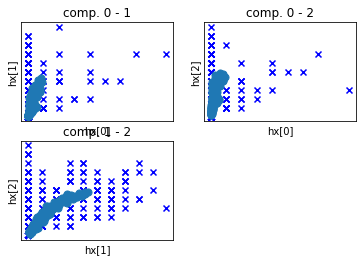

Finetune training
radius_ini: 0.300 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.0960  tErr : 0.7341
Epoch : 1 qErr : 0.0830  tErr : 0.7486
Epoch : 2 qErr : 0.0796  tErr : 0.7428
Epoch : 3 qErr : 0.0783  tErr : 0.7457
Epoch : 4 qErr : 0.0776  tErr : 0.7457
Epoch : 5 qErr : 0.0769  tErr : 0.7312
Epoch : 6 qErr : 0.0768  tErr : 0.7312
Epoch : 7 qErr : 0.0768  tErr : 0.7312
Epoch : 8 qErr : 0.0767  tErr : 0.7312
Epoch : 9 qErr : 0.0767  tErr : 0.7312
Epoch : 10 qErr : 0.0767  tErr : 0.7312
Epoch : 11 qErr : 0.0767  tErr : 0.7312
Epoch : 12 qErr : 0.0767  tErr : 0.7312
Epoch : 13 qErr : 0.0767  tErr : 0.7312
Epoch : 14 qErr : 0.0767  tErr : 0.7312
Epoch : 15 qErr : 0.0767  tErr : 0.7312
Epoch : 16 qErr : 0.0767  tErr : 0.7312
Epoch : 17 qErr : 0.0767  tErr : 0.7312
Epoch : 18 qErr : 0.0767  tErr : 0.7312
Epoch : 19 qErr : 0.0767  tErr : 0.7312
Epoch : 20 qErr : 0.0767  tErr : 0.7312
Epoch : 21 qErr : 0.0767  tErr : 0.7312
Epoch : 22 qErr : 0.0767  tErr : 0.7312
Epoch : 23 qErr :

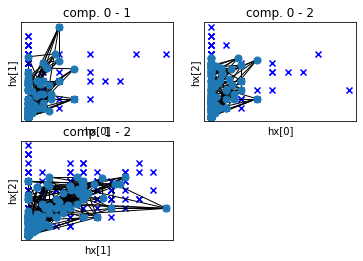

57it [10:17, 15.45s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1953  tErr : 0.7370
Epoch : 2 qErr : 0.1906  tErr : 0.7283
Epoch : 3 qErr : 0.1854  tErr : 0.7225
Epoch : 4 qErr : 0.1819  tErr : 0.7197
Epoch : 5 qErr : 0.1797  tErr : 0.7081
Epoch : 6 qErr : 0.1781  tErr : 0.7052
Epoch : 7 qErr : 0.1767  tErr : 0.7110
Epoch : 8 qErr : 0.1754  tErr : 0.7139
Epoch : 9 qErr : 0.1745  tErr : 0.7168
Epoch : 10 qErr : 0.1735  tErr : 0.7225
Epoch : 11 qErr : 0.1724  tErr : 0.7110
Epoch : 12 qErr : 0.1713  tErr : 0.7110
Epoch : 13 qErr : 0.1703  tErr : 0.7110
Epoch : 14 qErr : 0.1693  tErr : 0.7139
Epoch : 15 qErr : 0.1683  tErr : 0.7168
Epoch : 16 qErr : 0.1671  tErr : 0.7139
Epoch : 17 qErr : 0.1660  tErr : 0.7139
Epoch : 18 qErr : 0.1648  tErr : 0.7052
Epoch : 19 qErr : 0.1637  tErr : 0.7081
Epoch : 20 qErr : 0.1625  tErr : 0.7139
Epoch : 21 qErr : 0.1613  tErr : 0.7139
Epoch : 22 qErr : 0.1601  tErr : 0.7225
Epo

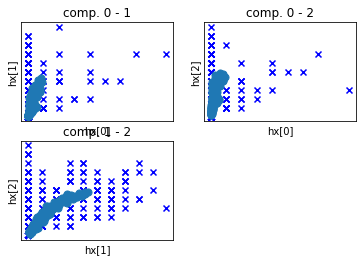

Finetune training
radius_ini: 0.700 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1233  tErr : 0.7457
Epoch : 1 qErr : 0.1186  tErr : 0.7399
Epoch : 2 qErr : 0.1155  tErr : 0.7341
Epoch : 3 qErr : 0.1132  tErr : 0.7312
Epoch : 4 qErr : 0.1111  tErr : 0.7370
Epoch : 5 qErr : 0.1092  tErr : 0.7370
Epoch : 6 qErr : 0.1070  tErr : 0.7428
Epoch : 7 qErr : 0.1049  tErr : 0.7399
Epoch : 8 qErr : 0.1027  tErr : 0.7457
Epoch : 9 qErr : 0.1005  tErr : 0.7486
Epoch : 10 qErr : 0.0978  tErr : 0.7486
Epoch : 11 qErr : 0.0953  tErr : 0.7486
Epoch : 12 qErr : 0.0922  tErr : 0.7572
Epoch : 13 qErr : 0.0892  tErr : 0.7601
Epoch : 14 qErr : 0.0867  tErr : 0.7688
Epoch : 15 qErr : 0.0843  tErr : 0.7717
Epoch : 16 qErr : 0.0817  tErr : 0.7717
Epoch : 17 qErr : 0.0793  tErr : 0.7803
Epoch : 18 qErr : 0.0778  tErr : 0.7861
Epoch : 19 qErr : 0.0766  tErr : 0.7861
Epoch : 20 qErr : 0.0759  tErr : 0.7890
Epoch : 21 qErr : 0.0755  tErr : 0.7890
Epoch : 22 qErr : 0.0754  tErr : 0.7890
Epoch : 23 qErr :

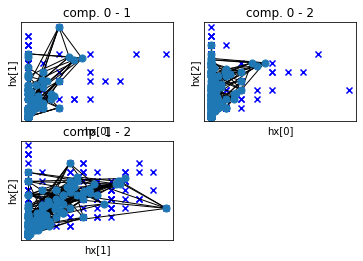

58it [10:44, 18.90s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1953  tErr : 0.7370
Epoch : 2 qErr : 0.1906  tErr : 0.7283
Epoch : 3 qErr : 0.1854  tErr : 0.7225
Epoch : 4 qErr : 0.1819  tErr : 0.7197
Epoch : 5 qErr : 0.1797  tErr : 0.7081
Epoch : 6 qErr : 0.1781  tErr : 0.7052
Epoch : 7 qErr : 0.1767  tErr : 0.7110
Epoch : 8 qErr : 0.1754  tErr : 0.7139
Epoch : 9 qErr : 0.1745  tErr : 0.7168
Epoch : 10 qErr : 0.1735  tErr : 0.7225
Epoch : 11 qErr : 0.1724  tErr : 0.7110
Epoch : 12 qErr : 0.1713  tErr : 0.7110
Epoch : 13 qErr : 0.1703  tErr : 0.7110
Epoch : 14 qErr : 0.1693  tErr : 0.7139
Epoch : 15 qErr : 0.1683  tErr : 0.7168
Epoch : 16 qErr : 0.1671  tErr : 0.7139
Epoch : 17 qErr : 0.1660  tErr : 0.7139
Epoch : 18 qErr : 0.1648  tErr : 0.7052
Epoch : 19 qErr : 0.1637  tErr : 0.7081
Epoch : 20 qErr : 0.1625  tErr : 0.7139
Epoch : 21 qErr : 0.1613  tErr : 0.7139
Epoch : 22 qErr : 0.1601  tErr : 0.7225
Epo

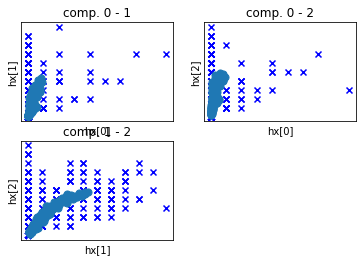

Finetune training
radius_ini: 1.100 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1434  tErr : 0.7486
Epoch : 1 qErr : 0.1414  tErr : 0.7486
Epoch : 2 qErr : 0.1391  tErr : 0.7457
Epoch : 3 qErr : 0.1367  tErr : 0.7428
Epoch : 4 qErr : 0.1346  tErr : 0.7428
Epoch : 5 qErr : 0.1326  tErr : 0.7399
Epoch : 6 qErr : 0.1306  tErr : 0.7370
Epoch : 7 qErr : 0.1284  tErr : 0.7370
Epoch : 8 qErr : 0.1260  tErr : 0.7283
Epoch : 9 qErr : 0.1240  tErr : 0.7370
Epoch : 10 qErr : 0.1215  tErr : 0.7457
Epoch : 11 qErr : 0.1189  tErr : 0.7457
Epoch : 12 qErr : 0.1165  tErr : 0.7428
Epoch : 13 qErr : 0.1138  tErr : 0.7341
Epoch : 14 qErr : 0.1108  tErr : 0.7370
Epoch : 15 qErr : 0.1078  tErr : 0.7341
Epoch : 16 qErr : 0.1042  tErr : 0.7457
Epoch : 17 qErr : 0.1005  tErr : 0.7428
Epoch : 18 qErr : 0.0968  tErr : 0.7428
Epoch : 19 qErr : 0.0923  tErr : 0.7514
Epoch : 20 qErr : 0.0876  tErr : 0.7601
Epoch : 21 qErr : 0.0839  tErr : 0.7688
Epoch : 22 qErr : 0.0805  tErr : 0.7601
Epoch : 23 qErr :

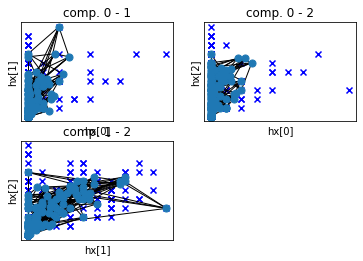

59it [11:11, 21.30s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1953  tErr : 0.7370
Epoch : 2 qErr : 0.1906  tErr : 0.7283
Epoch : 3 qErr : 0.1854  tErr : 0.7225
Epoch : 4 qErr : 0.1819  tErr : 0.7197
Epoch : 5 qErr : 0.1797  tErr : 0.7081
Epoch : 6 qErr : 0.1781  tErr : 0.7052
Epoch : 7 qErr : 0.1767  tErr : 0.7110
Epoch : 8 qErr : 0.1754  tErr : 0.7139
Epoch : 9 qErr : 0.1745  tErr : 0.7168
Epoch : 10 qErr : 0.1735  tErr : 0.7225
Epoch : 11 qErr : 0.1724  tErr : 0.7110
Epoch : 12 qErr : 0.1713  tErr : 0.7110
Epoch : 13 qErr : 0.1703  tErr : 0.7110
Epoch : 14 qErr : 0.1693  tErr : 0.7139
Epoch : 15 qErr : 0.1683  tErr : 0.7168
Epoch : 16 qErr : 0.1671  tErr : 0.7139
Epoch : 17 qErr : 0.1660  tErr : 0.7139
Epoch : 18 qErr : 0.1648  tErr : 0.7052
Epoch : 19 qErr : 0.1637  tErr : 0.7081
Epoch : 20 qErr : 0.1625  tErr : 0.7139
Epoch : 21 qErr : 0.1613  tErr : 0.7139
Epoch : 22 qErr : 0.1601  tErr : 0.7225
Epo

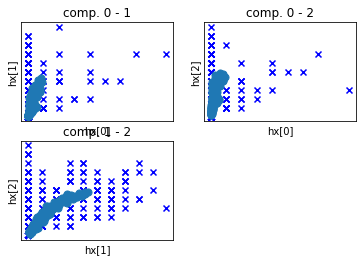

Finetune training
radius_ini: 1.500 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1628  tErr : 0.7341
Epoch : 1 qErr : 0.1605  tErr : 0.7312
Epoch : 2 qErr : 0.1583  tErr : 0.7312
Epoch : 3 qErr : 0.1559  tErr : 0.7312
Epoch : 4 qErr : 0.1536  tErr : 0.7283
Epoch : 5 qErr : 0.1512  tErr : 0.7370
Epoch : 6 qErr : 0.1488  tErr : 0.7486
Epoch : 7 qErr : 0.1463  tErr : 0.7543
Epoch : 8 qErr : 0.1438  tErr : 0.7543
Epoch : 9 qErr : 0.1412  tErr : 0.7514
Epoch : 10 qErr : 0.1385  tErr : 0.7486
Epoch : 11 qErr : 0.1353  tErr : 0.7457
Epoch : 12 qErr : 0.1325  tErr : 0.7312
Epoch : 13 qErr : 0.1294  tErr : 0.7341
Epoch : 14 qErr : 0.1262  tErr : 0.7370
Epoch : 15 qErr : 0.1232  tErr : 0.7370
Epoch : 16 qErr : 0.1197  tErr : 0.7428
Epoch : 17 qErr : 0.1161  tErr : 0.7341
Epoch : 18 qErr : 0.1124  tErr : 0.7341
Epoch : 19 qErr : 0.1082  tErr : 0.7370
Epoch : 20 qErr : 0.1028  tErr : 0.7572
Epoch : 21 qErr : 0.0969  tErr : 0.7601
Epoch : 22 qErr : 0.0908  tErr : 0.7572
Epoch : 23 qErr :

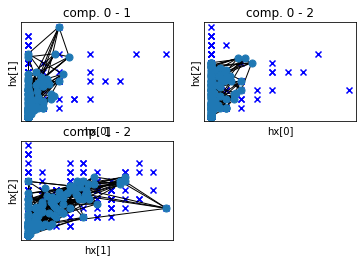

60it [11:38, 23.07s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1953  tErr : 0.7370
Epoch : 2 qErr : 0.1906  tErr : 0.7283
Epoch : 3 qErr : 0.1854  tErr : 0.7225
Epoch : 4 qErr : 0.1819  tErr : 0.7197
Epoch : 5 qErr : 0.1797  tErr : 0.7081
Epoch : 6 qErr : 0.1781  tErr : 0.7052
Epoch : 7 qErr : 0.1767  tErr : 0.7110
Epoch : 8 qErr : 0.1754  tErr : 0.7139
Epoch : 9 qErr : 0.1745  tErr : 0.7168
Epoch : 10 qErr : 0.1735  tErr : 0.7225
Epoch : 11 qErr : 0.1724  tErr : 0.7110
Epoch : 12 qErr : 0.1713  tErr : 0.7110
Epoch : 13 qErr : 0.1703  tErr : 0.7110
Epoch : 14 qErr : 0.1693  tErr : 0.7139
Epoch : 15 qErr : 0.1683  tErr : 0.7168
Epoch : 16 qErr : 0.1671  tErr : 0.7139
Epoch : 17 qErr : 0.1660  tErr : 0.7139
Epoch : 18 qErr : 0.1648  tErr : 0.7052
Epoch : 19 qErr : 0.1637  tErr : 0.7081
Epoch : 20 qErr : 0.1625  tErr : 0.7139
Epoch : 21 qErr : 0.1613  tErr : 0.7139
Epoch : 22 qErr : 0.1601  tErr : 0.7225
Epo

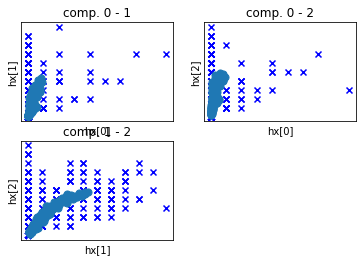

Finetune training
radius_ini: 1.900 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1788  tErr : 0.7254
Epoch : 1 qErr : 0.1762  tErr : 0.7254
Epoch : 2 qErr : 0.1740  tErr : 0.7312
Epoch : 3 qErr : 0.1715  tErr : 0.7312
Epoch : 4 qErr : 0.1691  tErr : 0.7341
Epoch : 5 qErr : 0.1665  tErr : 0.7312
Epoch : 6 qErr : 0.1637  tErr : 0.7370
Epoch : 7 qErr : 0.1609  tErr : 0.7370
Epoch : 8 qErr : 0.1580  tErr : 0.7428
Epoch : 9 qErr : 0.1551  tErr : 0.7399
Epoch : 10 qErr : 0.1519  tErr : 0.7399
Epoch : 11 qErr : 0.1487  tErr : 0.7428
Epoch : 12 qErr : 0.1457  tErr : 0.7486
Epoch : 13 qErr : 0.1424  tErr : 0.7486
Epoch : 14 qErr : 0.1389  tErr : 0.7370
Epoch : 15 qErr : 0.1351  tErr : 0.7428
Epoch : 16 qErr : 0.1315  tErr : 0.7428
Epoch : 17 qErr : 0.1280  tErr : 0.7399
Epoch : 18 qErr : 0.1241  tErr : 0.7399
Epoch : 19 qErr : 0.1194  tErr : 0.7572
Epoch : 20 qErr : 0.1148  tErr : 0.7457
Epoch : 21 qErr : 0.1096  tErr : 0.7486
Epoch : 22 qErr : 0.1034  tErr : 0.7514
Epoch : 23 qErr :

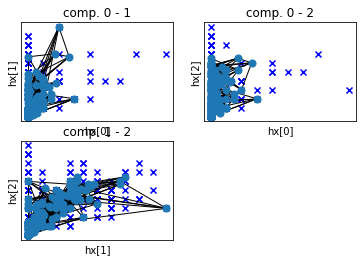

61it [12:05, 24.28s/it]

Training ...
 Rough training...
radius_ini: 2.000 , radius_final: 1.250, trainlen: 30

Epoch : 0 qErr : 0.2016  tErr : 0.7428
Epoch : 1 qErr : 0.1953  tErr : 0.7370
Epoch : 2 qErr : 0.1906  tErr : 0.7283
Epoch : 3 qErr : 0.1854  tErr : 0.7225
Epoch : 4 qErr : 0.1819  tErr : 0.7197
Epoch : 5 qErr : 0.1797  tErr : 0.7081
Epoch : 6 qErr : 0.1781  tErr : 0.7052
Epoch : 7 qErr : 0.1767  tErr : 0.7110
Epoch : 8 qErr : 0.1754  tErr : 0.7139
Epoch : 9 qErr : 0.1745  tErr : 0.7168
Epoch : 10 qErr : 0.1735  tErr : 0.7225
Epoch : 11 qErr : 0.1724  tErr : 0.7110
Epoch : 12 qErr : 0.1713  tErr : 0.7110
Epoch : 13 qErr : 0.1703  tErr : 0.7110
Epoch : 14 qErr : 0.1693  tErr : 0.7139
Epoch : 15 qErr : 0.1683  tErr : 0.7168
Epoch : 16 qErr : 0.1671  tErr : 0.7139
Epoch : 17 qErr : 0.1660  tErr : 0.7139
Epoch : 18 qErr : 0.1648  tErr : 0.7052
Epoch : 19 qErr : 0.1637  tErr : 0.7081
Epoch : 20 qErr : 0.1625  tErr : 0.7139
Epoch : 21 qErr : 0.1613  tErr : 0.7139
Epoch : 22 qErr : 0.1601  tErr : 0.7225
Epo

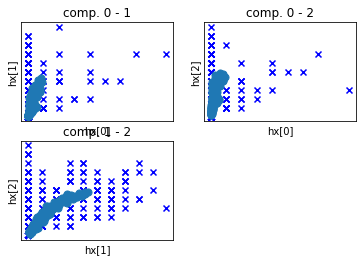

Finetune training
radius_ini: 2.300 , radius_final: 0.100, trainlen: 30

Epoch : 0 qErr : 0.1911  tErr : 0.7370
Epoch : 1 qErr : 0.1880  tErr : 0.7341
Epoch : 2 qErr : 0.1856  tErr : 0.7457
Epoch : 3 qErr : 0.1830  tErr : 0.7514
Epoch : 4 qErr : 0.1804  tErr : 0.7514
Epoch : 5 qErr : 0.1777  tErr : 0.7457
Epoch : 6 qErr : 0.1751  tErr : 0.7543


61it [12:21, 12.16s/it]


KeyboardInterrupt: 

In [51]:
from tqdm import tqdm 
import math
from sklearn.metrics import accuracy_score

max_score = -math.inf
best_config = {"epochs":0,"t_pahse1":0,"t_phase2":0}
combinations = itertools.product(epochs,tmp_phase1,tmp_phase2)
for num_epochs,t_pahse1,t_phase2 in tqdm(combinations):
    sm.train(n_job=1, 
         verbose=None, 
         train_rough_len=num_epochs, 
         train_rough_radiusin=t_pahse1,
         train_rough_radiusfin=1.25,
         train_finetune_len=num_epochs,
         train_finetune_radiusin=t_phase2,
         train_finetune_radiusfin=0.10,
         watch_evolution = False)
    
    classnames_ = classnames
    classnames_.append('Nan')
    classnames_ = np.array(classnames_)
    #get neurone labels
    sm.node_labels_from_data(sData_train)
    neuron_labels = np.array(sm.node_labels)
    #get true labels
    classes_desirees = np.array([reverse_classnames[x] for x in data_labels_val])
    #get predicted labels
    sData_val = SOMData(data_val)
    data_labels_estim =neuron_labels[sm.find_bmu(data_val).astype(int).T[:,0]]
    classes_estimees = np.array([reverse_classnames[x] for x in data_labels_estim])
    score = accuracy_score(classes_desirees,classes_estimees)
    if score > max_score :
        max_score = score
        best_config["epochs"] = num_epochs
        best_config["t_pahse1"] = t_pahse1
        best_config["t_pahse2"] = t_phase2
        print("new best score {}".format(score))
        
print(best_config)
print(max_score)

**Affichage des T-SNE**

In [ ]:
sData_test = SOMData(data_test)
sm.find_bmu(data_test).astype(int).T[:,0]

In [ ]:
sm._bmu[0].astype(int)

In [ ]:
#sm.plot_tsne()

#### Autres affichages graphiques :

- **Affichage de la carte**

In [ ]:
from mapview import View2D
dim = sData_train._dim
col_sz = 4
view2D  = View2D(16,4*(dim/col_sz),
                 "codage "+strChoix,
                 text_size=10)
view2D.show(sm, col_sz=col_sz, which_dim="all", denormalize=True) ; 

- **Affichage de la carte avec etiquettes (les indices des neurones)**

In [ ]:
view2D  = View2D(16,10,
                 "codage "+strChoix,
                 text_size=10) ;
view2D.show(sm, neuronLabels=None,anotate=True, col_sz=1, which_dim=1, denormalize=True, labelsize=16) ; 

 - **Affichage de la carte avec les cardinalités**

In [ ]:
from bmuhits import BmuHitsView
vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, logaritmic=False)

 - **Affichage de la carte (distances entre les référents/neurones)**

In [ ]:
from umatrix import UMatrixView
umat = UMatrixView(16,10,"Unified Distance Matrix", text_size=20)
umat.show(sm) ;

#### Evaluer l'apprentissage de la carte

* **Calcul des erreurs globales**

In [ ]:
topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error  = %s\nQuantization error = %s" % (topographic_error, quantization_error))

* **Coefficient de Silhouette**
(Pour cette partie on pourra voir la définition du [coefficient de Silhouette](https://fr.wikipedia.org/wiki/Silhouette_(clustering)) sur wikipedia ainsi que la documentation sur le site de scikit learn pour laquelle il y a un [tutoriel sur kmoyennes et silouhette](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html))    
En partitionnement de données (clustering), le coefficient de silhouette est une mesure de qualité d'une partition d'un ensemble de données en classification automatique. Pour chaque point, son coefficient de silhouette est la différence entre la distance moyenne avec les points du même groupe que lui (cohésion) et la distance moyenne avec les points des autres groupes voisins (séparation). Si cette différence est négative, le point est en moyenne plus proche du groupe voisin que du sien : il est donc mal classé. A l'inverse, si cette différence est positive, le point est en moyenne plus proche de son groupe que du groupe voisin : il est donc bien classé.

Le coefficient de silhouette proprement dit est la moyenne du coefficient de silhouette pour tous les points. 

In [ ]:
# sm._bmu = sm._bmu[0].astype(int)

In [ ]:
silhouette_avg = silhouette_score(sm._data, sm._bmu[0].astype(int))
silhouette_avg

In [ ]:
sample_silhouette_values = coefficientSilhouette = silhouette_samples(sData_train._data, sm._bmu[0].astype(int))
# sample_silhouette_values

#### Labellisation des neurones référents à partir des labels des données

In [ ]:
sm.node_labels_from_data(sData_train)

In [ ]:
neuron_labels = np.array(sm.node_labels)
print(neuron_labels)

 - **Affichage de la carte avec etiquettes (les votes)**

In [ ]:
view2D  = View2D(16,10,
                 "codage "+strChoix,
                 text_size=10) ;
view2D.show(sm, neuronLabels=sm.node_labels,anotate=True, col_sz=1, which_dim=1, denormalize=True,labelsize=12) ; 

#### Classification Ascendante Hiérarchique
- **Affichage du dendrogramme des référents**

In [ ]:
from dendrogram import DendrogramView
dendrogram = DendrogramView(10,10,"Dendrogramme de l'arbre hierarchique", text_size = 10)
dendrogram.show(sm)

In [ ]:
from hitmap import HitMapView
hits  = HitMapView(16,10,"Clustering",text_size=10)
hits.show??

In [ ]:
from hitmap import HitMapView
sm.cluster(10)
hits  = HitMapView(16,10,"Clustering",text_size=10)
a=hits.show(sm,labelsize=20)

#### Un peu de supervisé (pas toujours possible)
Comme les données sont associées à des classes, nous allons en profiter pour voir la correspondance entre les classes issues de la carte (déduites uniquement des entrées de la carte) et celles fournies avec les données.    
**On rappelle qu'il s'agit d'un algorithme non supervisé.**    
Ainsi, on ne prend pas en compte les classes lors de l'apprentissage.    
**On cherche donc à évaluer la capacité de la carte à discriminer ces classes. Cela ne pourra être fait que si les données des différentes classes sont bien distinctes dans l'espace des données (i.e. les entrées de la carte).** 

**Détermination des indices des classes estimées et désirées**

On ajoute la classe de rejet

In [ ]:
classnames_ = classnames
classnames_.append('Nan')
classnames_ = np.array(classnames_)
classnames_

Détermination des indices des classes désirées

In [ ]:
_,classes_desirees = np.where(data_labels_train[:,None]==np.array(classnames)[None,:])
#classes_desirees

In [ ]:
neuron_labels[sm._bmu[0].astype(int)]

Par précaution, on recalcule les etiquettes des neurones

In [ ]:
# classes esimees
data_labels_estim = neuron_labels[sm._bmu[0].astype(int)]
_, classes_estimees = np.where(data_labels_estim[:,None]==np.array(classnames)[None,:])
#classes_estimees

**Matrice de confusion**

In [ ]:
plt.figure(figsize=(10,10)) 
plot_confusion_matrix(classes_desirees, classes_estimees, classnames_,
                          title='', fontsize=12) ;

In [ ]:
#Test

In [ ]:
_,classes_desirees = np.where(data_labels_val[:,None]==np.array(classnames)[None,:])


In [ ]:
sData_val = SOMData(data_val)
data_labels_estim =neuron_labels[sm.find_bmu(data_val).astype(int).T[:,0]]
_, classes_estimees = np.where(data_labels_estim[:,None]==np.array(classnames)[None,:])

In [ ]:
plt.figure(figsize=(10,10)) 
plot_confusion_matrix(classes_desirees, classes_estimees, classnames_,
                          title='', fontsize=12) ;

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(classes_desirees,classes_estimees)